# CellSexID: Human Single-Cell Sex Prediction Analysis

This notebook demonstrates comprehensive sex prediction across multiple human single-cell RNA-seq datasets using machine learning approaches. We analyze four main datasets to validate the robustness and generalizability of sex classification methods:

## Datasets Analyzed
1. **Data1 ATL Dataset (GSE294224)**: Adult T-cell leukemia-lymphoma samples
2. **Kidney Dataset (GSE151671)**: Donor kidney cells for transplant analysis  
3. **Data2 (AML/MLL Dataset, GSE289435)**: Bone marrow mononuclear cells from AML patients
4. **Data3 (Thymic Dataset, GSE262749)**: Medullary thymic epithelial cells

All datasets in this analysis undergo identical preprocessing steps to ensure standardized and comparable results across different studies:

### **Standardized Quality Control & Preprocessing:**

1. **Gene Filtering**: `min_cells = 3` - Remove genes expressed in fewer than 3 cells
2. **Cell Filtering**: `min_genes = 200` - Remove cells expressing fewer than 200 genes  
3. **Mitochondrial Filtering**: `mt < 5%` - Remove cells with >5% mitochondrial gene expression
4. **Normalization**: `target_sum = 1e4` - Library-size normalize to 10,000 counts per cell
5. **Log Transformation**: `log1p` - Apply log(x + 1) transformation


## Methodology Overview
- **Feature Selection**: Sex-specific marker genes from X/Y chromosomes
- **Models**: Logistic Regression, Linear SVM, XGBoost, Random Forest
- **Validation Strategy**: Cross-dataset validation and statistical robustness testing
- **Performance Metrics**: AUROC, AUPRC, accuracy, precision, recall, F1-score

## Key Contributions
- Cross-dataset generalization analysis
- Optimal marker gene panel identification
- Statistical validation with multiple random seeds
- Performance comparison across tissue types and disease states

## Dataset 1: ATL (Adult T-cell Leukemia-Lymphoma) Analysis

## Data Processing and Quality Control
Processing of three 10X Genomics datasets (ATL1, ATL2, ATL3) from adult T-cell leukemia-lymphoma samples. This analysis includes data loading, quality control filtering, and preparation for downstream sex prediction modeling.

In [2]:
#!/usr/bin/env python3
"""
ATL scRNA-seq merge + QC • GSE294224
─────────────────────────────────────
- Load three 10X Genomics datasets (ATL1, ATL2, ATL3)
- Prefix barcodes with sample name
- Concatenate matrices
- Assign sex labels based on patient information
- Perform QC filtering (min_genes, mitochondrial content)
- Library-size normalize, log1p transform
- Save sparse .h5ad
"""

import os
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import scipy.io as spio  # Correct import for mmread
import sys

# ───────────── USER PATHS ─────────────
DATA_DIR = "data/GSE294224_RAW"
OUTDIR = "data/human_1"
OUTFILE = os.path.join(OUTDIR, "atl_merged_qc.h5ad")

# Create output directory if it doesn't exist
os.makedirs(OUTDIR, exist_ok=True)

# Sample information
samples = ["ATL1", "ATL2", "ATL3"]
# Sex labels according to your data
sex_labels = {"ATL1": "female", "ATL2": "male", "ATL3": "male"}

VERBOSE = True  # one-line progress prints

# ───────────── HELPERS ──────────────
def load_10x_data(sample: str, data_dir: str) -> sc.AnnData:
    """Load one 10X Genomics dataset using direct file loading."""
    if VERBOSE: print(f"• Loading {sample}")
    
    # Define file patterns based on the actual directory listing
    sample_id_mapping = {
        "ATL1": "8900566",
        "ATL2": "8900568",
        "ATL3": "8900570"
    }
    
    sample_id = sample_id_mapping[sample]
    
    # Correct file paths based on your directory listing
    matrix_file = os.path.join(data_dir, f"GSM{sample_id}_{sample}_matrix.mtx.gz")
    features_file = os.path.join(data_dir, f"GSM{sample_id}_{sample}_features.tsv.gz")
    barcodes_file = os.path.join(data_dir, f"GSM{sample_id}_{sample}_barcodes.tsv.gz")
    
    # Check if files exist
    for file_path in [matrix_file, features_file, barcodes_file]:
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
    
    try:
        # Load matrix - using the correct scipy.io module
        X = spio.mmread(matrix_file).T.tocsr()
        
        # Load features (genes)
        features = pd.read_csv(features_file, sep='\t', header=None)
        if features.shape[1] >= 2:
            # The second column typically contains gene symbols
            gene_names = features[1].values
        else:
            # If there's only one column, use it as both ID and name
            gene_names = features[0].values
        
        # Make gene names unique
        gene_names_unique = make_unique_names(gene_names)
        
        # Load barcodes
        barcodes = pd.read_csv(barcodes_file, sep='\t', header=None)[0].values
        
        # Create AnnData object
        adata = sc.AnnData(X=X)
        adata.obs_names = [f"{sample}_{bc}" for bc in barcodes]
        adata.var_names = gene_names_unique
        
        # Add sample and sex information
        adata.obs["sample"] = sample
        adata.obs["sex"] = sex_labels[sample]
        
        return adata
    
    except Exception as e:
        print(f"Error loading {sample}: {e}")
        return None

def make_unique_names(names):
    """Make duplicate names unique by appending numbers."""
    name_counts = {}
    unique_names = []
    
    for name in names:
        if name in name_counts:
            name_counts[name] += 1
            unique_names.append(f"{name}_{name_counts[name]}")
        else:
            name_counts[name] = 0
            unique_names.append(name)
    
    return unique_names

# ────────── 1) LOAD ALL SAMPLES ──────────
adatas = []
for sample in samples:
    adata = load_10x_data(sample, DATA_DIR)
    if adata is not None:
        adatas.append(adata)
        if VERBOSE:
            print(f"• Successfully loaded {sample}: {adata.n_obs} cells × {adata.n_vars} genes")
    else:
        print(f"❌ Failed to load {sample}")

# Check if we have data to work with
if not adatas:
    print("No data was successfully loaded. Exiting.")
    sys.exit(1)

# ────────── 2) CONCATENATE ──────────
if VERBOSE: print("• Concatenating datasets")
if len(adatas) == 1:
    # If only one dataset was loaded, skip concatenation
    adata = adatas[0].copy()
    print("Only one dataset was loaded, skipping concatenation")
else:
    # Concatenate multiple datasets
    adata = sc.concat(
        adatas,
        join="outer",     # Union of genes
        merge="first",
        fill_value=0,     # Fill gaps with 0
    )

# Ensure the data is sparse
if not sp.issparse(adata.X):
    adata.X = sp.csr_matrix(adata.X)

if VERBOSE:
    print(f"• Concatenated: {adata.n_obs:,} cells × {adata.n_vars:,} genes")

# ────────── 3) BASIC QC & FILTERING ──────────
if VERBOSE: print("• Performing QC and filtering")

# Filter genes with low expression
sc.pp.filter_genes(adata, min_cells=3)

# Filter cells with few expressed genes
sc.pp.filter_cells(adata, min_genes=200)

# Identify mitochondrial genes (human MT genes start with MT-)
adata.var["mt"] = adata.var_names.str.startswith("MT-")

# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

# Filter cells with high mitochondrial content
max_mito_percent = 5
adata = adata[adata.obs["pct_counts_mt"] < max_mito_percent, :].copy()

# ────────── 4) NORMALIZATION ──────────
if VERBOSE: print("• Normalizing data")
sc.pp.normalize_total(adata, target_sum=1e4, inplace=True)
sc.pp.log1p(adata)

# ────────── 5) WRITE OUTPUT ──────────
if VERBOSE: print(f"• Writing to {OUTFILE}")
adata.write(OUTFILE, compression="gzip")

# ────────── SUMMARY ──────────
print("✅ Finished:")
print(f"   Cells  : {adata.n_obs:,}")
print(f"   Genes  : {adata.n_vars:,}")
print("   Sex    :")
print(adata.obs["sex"].value_counts(dropna=False))
print("   Samples:")
print(adata.obs["sample"].value_counts())

• Loading ATL1
• Successfully loaded ATL1: 5066 cells × 36610 genes
• Loading ATL2
• Successfully loaded ATL2: 10151 cells × 36610 genes
• Loading ATL3
• Successfully loaded ATL3: 5095 cells × 36610 genes
• Concatenating datasets
• Concatenated: 20,312 cells × 36,610 genes
• Performing QC and filtering
• Normalizing data
• Writing to data/human_1/atl_merged_qc.h5ad
✅ Finished:
   Cells  : 9,292
   Genes  : 22,630
   Sex    :
sex
male      6481
female    2811
Name: count, dtype: int64
   Samples:
sample
ATL2    3982
ATL1    2811
ATL3    2499
Name: count, dtype: int64


## Cross-Dataset Validation: Data2(MLL) → Data1(ATL)
**Training Data**: Data2 (MLL/AML dataset, GSE289435) - Subsample
**Testing Data**: ATL dataset (GSE294224) - Data1

Training sex classification models on bone marrow mononuclear cells (Data2) and testing on adult T-cell leukemia-lymphoma samples (ATL/Data1). This cross-dataset validation tests generalizability from AML to ATL disease contexts.

In [6]:
#!/usr/bin/env python3
"""
Sex classification using MLL data (human_2) subsample as training and ATL data (human_1) as testing
Using 10 selected marker genes: RPS4Y1, EIF1AY, XIST, DDX3Y, UTY, KDM5D, IFIT3, IFIT2, RPS4X, RPL29
Models: LogisticRegression, Linear-SVC, XGBoost, Random-Forest
"""

# ─── imports ───────────────────────────────────────────────
import os, pathlib, warnings
import numpy as np, pandas as pd, scanpy as sc, scipy.sparse as sp
import matplotlib.pyplot as plt

from sklearn.impute            import SimpleImputer
from sklearn.preprocessing     import StandardScaler
from sklearn.pipeline          import Pipeline
from sklearn.linear_model      import LogisticRegression
from sklearn.svm               import SVC
from sklearn.ensemble          import RandomForestClassifier
from sklearn.model_selection   import train_test_split
from xgboost                   import XGBClassifier
from sklearn.metrics           import (
    accuracy_score, f1_score, roc_auc_score, average_precision_score,
    confusion_matrix, roc_curve, precision_recall_curve
)

# ─── selected marker panel ──────────────────────────────────────────
SELECTED_MARKERS =  [
    "RPS4Y1", 
    "EIF1AY", 
    "XIST", 
    "DDX3Y", 
    "UTY", 
    "KDM5D", 
    "IFIT3", 
    "IFIT2", 
    "RPS4X"
]

 
# ─── alias dictionary for gene name mapping ───────────────────
alias_to_official = {
    "XIST":"Xist", "RPS27RT":"Rps27rt", "DDX3Y":"Ddx3y", "RPL35":"Rpl35",
    "EIF2S3Y":"Eif2s3y", "EIF2S3L":"Eif2s3y", "GM42418":"Gm42418", "UBA52":"Uba52",
    "RPL36A-PS1":"Rpl36a-ps1", "KDM5D":"Kdm5d", "JARID1D":"Kdm5d", "WDR89":"Wdr89",
    "UTY":"Uty", "LARS2":"Lars2", "AY036118":"AY036118", "RPL9-PS6":"Rpl9-ps6", "RPS27":"Rps27",
    "RPS4Y1":"RPS4Y1", "EIF1AY":"EIF1AY", "IFIT3":"IFIT3", "IFIT2":"IFIT2", 
    "RPS4X":"RPS4X", "RPL29":"RPL29", 
    # Keep human gene names as-is since both datasets are human
}

# ─── file paths ────────────────────────────────────────────
DATA_DIR = "data"
MLL_H5AD = os.path.join(DATA_DIR, "human_2/mll_merged_qc.h5ad")
ATL_H5AD = os.path.join(DATA_DIR, "human_1/atl_merged_qc.h5ad")  # Now using ATL as test data
OUT_DIR = pathlib.Path("result/human2_human1_selected")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ─── helper functions ────────────────────────────────────────
def unify_gene_symbols(adata):
    """Normalize gene symbols using alias dictionary"""
    if not isinstance(adata.var_names, pd.Index):
        return adata
    
    # Create a mapping dictionary for renaming
    rename_dict = {}
    for gene in adata.var_names:
        # Check for aliases (case insensitive)
        gene_upper = gene.upper()
        if gene_upper in alias_to_official:
            rename_dict[gene] = alias_to_official[gene_upper]
    
    # Rename genes if aliases are found
    if rename_dict:
        print(f"Renaming {len(rename_dict)} genes using alias dictionary")
        adata.var_names = [rename_dict.get(g, g) for g in adata.var_names]
        
    # Make variable names unique if needed
    if not adata.var_names.is_unique:
        print("Making gene names unique")
        adata.var_names_make_unique()
        
    return adata

def extract_sex_labels(adata):
    """Extract standardized sex labels (0=female, 1=male)"""
    if "sex" not in adata.obs:
        raise ValueError("'sex' column not found in AnnData.")

    sex = (
        adata.obs["sex"]
          .astype(str).str.strip().str.lower()
          .map({"female": 0, "male": 1})
    )
    mask = sex.notna()
    return adata[mask].copy(), sex[mask].astype(int).values

def make_pipe(clf):
    """Create a preprocessing pipeline for a classifier"""
    steps = [("imp", SimpleImputer(strategy="median"))]
    if isinstance(clf, (LogisticRegression, SVC)):
        steps.append(("sc", StandardScaler(with_mean=False)))
    steps.append(("clf", clf))
    return Pipeline(steps)

def extract_marker_matrix(adata, markers):
    """Extract marker gene expression matrix from AnnData"""
    # Convert var_names to lowercase for case-insensitive matching
    var_lower = {g.lower(): g for g in adata.var_names}
    
    # Find markers present in dataset (case-insensitive)
    present = [var_lower[g.lower()] for g in markers if g.lower() in var_lower]
    
    if len(present) < 2:
        raise ValueError(f"Fewer than 2 marker genes present in dataset. Found: {present}")
    
    # Extract expression matrix as DataFrame
    X_df = pd.DataFrame(
        adata[:, present].X.A if sp.issparse(adata.X) else adata[:, present].X,
        index=adata.obs_names,
        columns=present,
    )
    
    # Drop constant columns that don't provide information
    nonconst = (X_df != X_df.iloc[0]).any()
    if (~nonconst).any():
        dropped = X_df.columns[~nonconst].tolist()
        warnings.warn(f"Dropping constant marker(s): {dropped}")
        X_df = X_df.loc[:, nonconst]
        present = X_df.columns.tolist()
    
    if len(present) < 2:
        raise ValueError("Need ≥2 informative markers after filtering.")
    
    print(f"Markers used ({len(present)}): {present}")
    
    return X_df, present

# ═════════ 1) Load datasets ══════════════════════════
print("Loading MLL dataset (training data)...")
mll_adata = sc.read_h5ad(MLL_H5AD)
mll_adata = unify_gene_symbols(mll_adata)
mll_adata, mll_y = extract_sex_labels(mll_adata)
print(f"MLL dataset: {mll_adata.n_obs:,} cells  "
      f"(♀ {(mll_y==0).sum()}  ♂ {(mll_y==1).sum()})")

print("\nLoading ATL dataset (test data)...")  # Changed to ATL as test data
test_adata = sc.read_h5ad(ATL_H5AD)
test_adata = unify_gene_symbols(test_adata)
test_adata, y_test = extract_sex_labels(test_adata)
print(f"ATL dataset: {test_adata.n_obs:,} cells  "  # Changed to ATL
      f"(♀ {(y_test==0).sum()}  ♂ {(y_test==1).sum()})")

# ═════════ 2) Subsample MLL dataset (1/15) ══════════════════
print("\nExtracting 1/15 random subsample from MLL dataset...")
subsample_size = len(mll_adata) // 15

indices = np.arange(len(mll_adata))
_, subsample_indices, _, y_subsample = train_test_split(
    indices, mll_y, test_size=subsample_size/len(mll_adata), 
    stratify=mll_y, random_state=42
)

# Create subsampled AnnData object for training
train_adata = mll_adata[subsample_indices].copy()
y_train = mll_y[subsample_indices]
print(f"Training subsample: {train_adata.n_obs:,} cells  "
      f"(♀ {(y_train==0).sum()}  ♂ {(y_train==1).sum()})")
print(f"Subsampling ratio: {train_adata.n_obs/mll_adata.n_obs:.1%} of original MLL data")

# ═════════ 3) Extract marker matrices ══════════════════
print("\nExtracting selected marker genes from training data...")
X_train_df, train_markers = extract_marker_matrix(train_adata, SELECTED_MARKERS)

print("\nExtracting selected marker genes from test data...")
X_test_df, test_markers = extract_marker_matrix(test_adata, SELECTED_MARKERS)

# Find common markers between train and test sets
common_markers = sorted(set(train_markers) & set(test_markers))
if len(common_markers) < 2:
    raise ValueError(f"Fewer than 2 common marker genes between datasets. Found: {common_markers}")

print(f"\nCommon markers used for training and testing ({len(common_markers)}): {common_markers}")

# Use only common markers
X_train = X_train_df[common_markers].values
X_test = X_test_df[common_markers].values

# ═════════ 4) Define models ══════════════════════════
pipelines = {
    "LogisticRegression": make_pipe(LogisticRegression(max_iter=1000, random_state=42)),
    "LinearSVC": make_pipe(SVC(kernel="linear", probability=True, random_state=42)),
    "XGBoost": make_pipe(XGBClassifier(
        eval_metric="logloss", random_state=42,
        n_estimators=100, learning_rate=0.05, max_depth=10)),
    "RandomForest": make_pipe(RandomForestClassifier(max_depth=10, random_state=42)),
}

# Set up for curve data collection and plotting
curve_data_roc = []
curve_data_pr = []
colors = {
    "LogisticRegression": "blue",
    "LinearSVC": "red",
    "XGBoost": "green",
    "RandomForest": "purple"
}

# Create figures for plotting
fig_roc, ax_roc = plt.subplots(figsize=(10, 8))
fig_pr, ax_pr = plt.subplots(figsize=(10, 8))

# ═════════ 5) Train and evaluate models ══════════════════
print("\n" + "="*50)
print("Training and evaluating models using selected genes")
print("="*50)

results = []
for name, model in pipelines.items():
    print(f"\n=== {name} ===")
    model.fit(X_train, y_train)

    # 1) Train performance
    p_tr = model.predict(X_train)
    prob_tr = model.predict_proba(X_train)[:, 1]
    tr_acc = accuracy_score(y_train, p_tr)
    tr_f1 = f1_score(y_train, p_tr)
    tr_roc = roc_auc_score(y_train, prob_tr)
    tr_pr = average_precision_score(y_train, prob_tr)
    print(f" TRAIN → Acc={tr_acc:.4f}, F1={tr_f1:.4f}, AUROC={tr_roc:.4f}, AUPRC={tr_pr:.4f}")

    # 2) Test performance
    p_test = model.predict(X_test)
    prob_test = model.predict_proba(X_test)[:, 1]
    test_acc = accuracy_score(y_test, p_test)
    test_f1 = f1_score(y_test, p_test)
    test_roc = roc_auc_score(y_test, prob_test)
    test_pr = average_precision_score(y_test, prob_test)
    print(f" TEST → Acc={test_acc:.4f}, F1={test_f1:.4f}, AUROC={test_roc:.4f}, AUPRC={test_pr:.4f}")
    print("  Confusion Matrix:")
    print(confusion_matrix(y_test, p_test))
    
    results.append({
        "Model": name,
        "Train_Acc": tr_acc, "Train_F1": tr_f1,
        "Train_AUROC": tr_roc, "Train_AUPRC": tr_pr,
        "Test_Acc": test_acc, "Test_F1": test_f1,
        "Test_AUROC": test_roc, "Test_AUPRC": test_pr,
    })
    
    # Calculate ROC curve points
    fpr, tpr, _ = roc_curve(y_test, prob_test)
    roc_df = pd.DataFrame({"model": name, "fpr": fpr, "tpr": tpr})
    curve_data_roc.append(roc_df)
    
    # Calculate PR curve points
    precision, recall, _ = precision_recall_curve(y_test, prob_test)
    pr_df = pd.DataFrame({"model": name, "precision": precision, "recall": recall})
    curve_data_pr.append(pr_df)
    
    # Plot ROC curve
    ax_roc.plot(fpr, tpr, lw=2, color=colors[name], 
             label=f'{name} (area = {test_roc:.3f})')
    
    # Plot PR curve
    ax_pr.plot(recall, precision, lw=2, color=colors[name], 
            label=f'{name} (area = {test_pr:.3f})')

# ═════════ 6) Save results ══════════════════════════
# Combine and save curve data
all_roc_data = pd.concat(curve_data_roc, ignore_index=True)
all_pr_data = pd.concat(curve_data_pr, ignore_index=True)

all_roc_data.to_csv(OUT_DIR / "human2_to_human1_selected_auroc.csv", index=False)
all_pr_data.to_csv(OUT_DIR / "human2_to_human1_selected_auprc.csv", index=False)

# Finalize and save ROC plot
ax_roc.plot([0, 1], [0, 1], 'k--', lw=2)
ax_roc.set_xlim([0.0, 1.0])
ax_roc.set_ylim([0.0, 1.05])
ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.set_title('Human2 (MLL) → Human1 (ATL): ROC Curves (Selected Genes)')
ax_roc.legend(loc="lower right")
ax_roc.grid(True, linestyle='--', alpha=0.7)
fig_roc.tight_layout()
fig_roc.savefig(OUT_DIR / "human2_to_human1_selected_roc_curves.png", dpi=300, bbox_inches='tight')

# Finalize and save PR plot
ax_pr.set_xlabel('Recall')
ax_pr.set_ylabel('Precision')
ax_pr.set_ylim([0.0, 1.05])
ax_pr.set_xlim([0.0, 1.0])
ax_pr.set_title('Human2 (MLL) → Human1 (ATL): Precision-Recall Curves (Selected Genes)')
ax_pr.legend(loc="lower left")
ax_pr.grid(True, linestyle='--', alpha=0.7)
fig_pr.tight_layout()
fig_pr.savefig(OUT_DIR / "human2_to_human1_selected_pr_curves.png", dpi=300, bbox_inches='tight')

plt.close('all')

# Save summary results
results_df = pd.DataFrame(results)
print("\nFinal results:")
print(results_df)

results_df.to_csv(OUT_DIR / "human2_to_human1_selected_summary_results.csv", index=False)
print(f"\nAll results saved to {OUT_DIR}")

Loading MLL dataset (training data)...
Renaming 15 genes using alias dictionary
MLL dataset: 87,171 cells  (♀ 44716  ♂ 42455)

Loading ATL dataset (test data)...
Renaming 15 genes using alias dictionary
ATL dataset: 9,292 cells  (♀ 2811  ♂ 6481)

Extracting 1/15 random subsample from MLL dataset...
Training subsample: 5,811 cells  (♀ 2981  ♂ 2830)
Subsampling ratio: 6.7% of original MLL data

Extracting selected marker genes from training data...
Markers used (9): ['RPS4Y1', 'EIF1AY', 'Xist', 'Ddx3y', 'Uty', 'Kdm5d', 'IFIT3', 'IFIT2', 'RPS4X']

Extracting selected marker genes from test data...
Markers used (9): ['RPS4Y1', 'EIF1AY', 'Xist', 'Ddx3y', 'Uty', 'Kdm5d', 'IFIT3', 'IFIT2', 'RPS4X']

Common markers used for training and testing (9): ['Ddx3y', 'EIF1AY', 'IFIT2', 'IFIT3', 'Kdm5d', 'RPS4X', 'RPS4Y1', 'Uty', 'Xist']

Training and evaluating models using selected genes

=== LogisticRegression ===
 TRAIN → Acc=0.8954, F1=0.8816, AUROC=0.9615, AUPRC=0.9641
 TEST → Acc=0.9523, F1=0.96

## Kidney Dataset: Donor Cell Analysis (GSE151671)

## Overview
Analysis of donor kidney cells for unbiased expression-sex analysis. This dataset serves as an important validation set for testing model generalizability across tissue types, as kidney samples represent healthy donor tissue without disease-related expression changes.

In [ ]:
#!/usr/bin/env python3
"""
Kidney scRNA-seq merge + QC (UNBIASED VERSION)  •  GSE151671
──────────────────────────────────────────────────────────
FOCUS: Only donor kidney cells for unbiased expression-sex analysis
• Load three DGE tables (HK, AK1, AK2)  
• Filter to keep ONLY parenchymal/kidney-resident cells (donor cells)
• Assign sex based on DONOR sex (not recipient)
• Remove recipient immune cells that confound sex-expression analysis
• Save clean donor kidney dataset
"""

import os, warnings
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp

# ───────────── USER PATHS ─────────────
DATA_DIR = "data/GSE151671_RAW"
data_files = {
    "HK":  "GSM4587971_HK.dge.txt.gz",    # female healthy kidney
    "AK1": "GSM4587972_AK1.dge.txt.gz",   # female recipient, MALE DONOR
    "AK2": "GSM4587973_AK2.dge.txt.gz",   # male recipient, FEMALE DONOR
}
METADATA_PATH = "data/GSE151671_Cell_barcode_assignment.xlsx"
OUTFILE       = os.path.join(DATA_DIR, "kidney_unbias.h5ad")

VERBOSE = True
TRACE_ASSIGN_SEX = False

# ───────────── KIDNEY CELL TYPES ──────────────
# Only parenchymal/resident kidney cells (DONOR cells)
_kidney_parenchymal = {
    "PT", "PT1", "PT2", "PG", "LH", "CD", "IC-A", "IC-B", 
    "PTC1", "PTC2", "PTC3", "DVR", "FB1", "FB2", "FB3", "FB4",
    "EC", "PC1", "PC2", "VSMC1", "VSMC2", "VSMC3", "VSMC4",
}

# Immune/circulating cells to EXCLUDE (these are recipient cells)
_immune_circulating = {
    "B", "T", "NK", "Macro", "DC", "Neutrophil", "Monocyte", 
    "Lymphocyte", "Plasma", "Mast"
}

def is_kidney_cell(cell_type: str) -> bool:
    """Check if cell type is kidney parenchymal (donor) cell."""
    if pd.isna(cell_type):
        return False
    c = str(cell_type).upper().strip()
    
    # Direct match or substring match for parenchymal
    is_parenchymal = any(t == c or t in c or c.startswith(t) for t in _kidney_parenchymal)
    
    # Exclude if clearly immune/circulating
    is_immune = any(t in c or c.startswith(t) for t in _immune_circulating)
    
    return is_parenchymal and not is_immune

def assign_donor_sex(sample: str, cell_type: str) -> str:
    """Return donor sex for kidney cells only."""
    if not is_kidney_cell(cell_type):
        return "exclude"  # Mark for removal
    
    if TRACE_ASSIGN_SEX:
        print(f"assign_donor_sex({sample}, {cell_type}) -> kidney cell")
    
    # Sex assignment based on DONOR
    s = sample.upper()
    if s == "HK":  return "female"  # healthy female kidney
    if s == "AK1": return "male"    # male donor kidney  
    if s == "AK2": return "female"  # female donor kidney
    return "unknown"

def read_dge(sample: str, path: str) -> sc.AnnData:
    """Load one DGE file → AnnData with prefixed barcodes."""
    if VERBOSE: print(f"• Loading {sample}")
    df = pd.read_csv(path, sep="\t", index_col=0)
    if df.shape[0] > df.shape[1]:
        df = df.T
    if df.isna().values.any():
        df = df.fillna(0)
    barcodes = [f"{sample}_{bc}" for bc in df.index]
    adata = sc.AnnData(
        X   = sp.csr_matrix(df.values),
        obs = pd.DataFrame(index=barcodes),
        var = pd.DataFrame(index=df.columns),
    )
    adata.obs["sample"] = sample
    return adata

# ────────── 1) LOAD ALL SAMPLES ──────────
adatas = [
    read_dge(s, os.path.join(DATA_DIR, f))
    for s, f in data_files.items()
]

# ────────── 2) CONCATENATE ──────────
adata = sc.concat(
    adatas,
    join       = "outer",
    merge      = "first", 
    fill_value = 0,
)

if not sp.issparse(adata.X):
    adata.X = sp.csr_matrix(adata.X)
if VERBOSE:
    print(f"• Concatenated: {adata.n_obs:,} cells × {adata.n_vars:,} genes")

# ────────── 3) MERGE METADATA ──────────
meta = (
    pd.read_excel(METADATA_PATH, engine="openpyxl")
      .rename(columns=lambda x: x.strip())
      .assign(Cell_barcode=lambda d: d["Cell_barcode"].astype(str).str.strip().str.upper())
      .set_index("Cell_barcode")
)
adata.obs = adata.obs.merge(meta, left_index=True, right_index=True, how="left")

# ────────── 4) FILTER TO KIDNEY CELLS ONLY ──────────
if "Cell_type" not in adata.obs.columns:
    warnings.warn("Metadata lacks 'Cell_type'; cannot filter kidney cells.")
    adata.obs["Cell_type"] = "unknown"

# Assign donor sex and filter
adata.obs["donor_sex"] = adata.obs.apply(
    lambda r: assign_donor_sex(r["sample"], r["Cell_type"]), axis=1
)

# Keep only kidney cells (exclude immune/circulating cells)
before_filter = adata.n_obs
kidney_mask = adata.obs["donor_sex"] != "exclude"
adata = adata[kidney_mask, :].copy()

if VERBOSE:
    print(f"• Filtered to kidney cells: {before_filter:,} → {adata.n_obs:,} cells")
    print("• Donor sex distribution:")
    print(adata.obs["donor_sex"].value_counts(dropna=False))
    print("• Sample distribution:")  
    print(adata.obs["sample"].value_counts())
    print("• Cell types kept:")
    print(adata.obs["Cell_type"].value_counts().head(10))

# ────────── 5) BASIC QC & NORMALISATION ──────────
# Filter genes (min 3 cells)
sc.pp.filter_genes(adata, min_cells=3)

# Filter cells (min 200 genes)
sc.pp.filter_cells(adata, min_genes=200)

# Mitochondrial QC
adata.var["mt"] = adata.var_names.str.startswith(("MT-", "mt-"))
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

 

# Normalize and log-transform
sc.pp.normalize_total(adata, target_sum=1e4, inplace=True)
sc.pp.log1p(adata)

# Add additional metadata
adata.obs["dataset"] = "kidney_unbias"
adata.obs["filtered_for"] = "donor_kidney_cells_only"

# ────────── 6) SAVE RESULTS ──────────
adata.write(OUTFILE, compression="gzip")

# ────────── SUMMARY ──────────
print("\n" + "="*50)
print("✅ KIDNEY_UNBIAS COMPLETED")
print("="*50)
print(f"Final dataset: {adata.n_obs:,} cells × {adata.n_vars:,} genes")
print(f"Saved to: {OUTFILE}")
print("\nDONOR SEX DISTRIBUTION:")
print(adata.obs["donor_sex"].value_counts(dropna=False))
print("\nSAMPLE DISTRIBUTION:")
print(adata.obs["sample"].value_counts())
print("\nTOP CELL TYPES (kidney only):")
print(adata.obs["Cell_type"].value_counts().head(10))

print(f"\n🎯 FOCUS: Only donor kidney cells included")
print(f"   • HK cells: female donor (healthy)")  
print(f"   • AK1 cells: male donor (transplanted)")
print(f"   • AK2 cells: female donor (transplanted)")
print(f"   • Excluded: All recipient immune/circulating cells")
print(f"   • Ready for unbiased sex-expression analysis!")

• Loading HK
• Loading AK1
• Loading AK2
• Concatenated: 18,000 cells × 21,203 genes


/Users/haley/Library/Python/3.9/lib/python/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


• Filtered to kidney cells: 18,000 → 1,404 cells
• Donor sex distribution:
donor_sex
female    1200
male       204
Name: count, dtype: int64
• Sample distribution:
sample
HK     1019
AK1     204
AK2     181
Name: count, dtype: int64
• Cell types kept:
Cell_type
vSMC2    265
CD       235
vSMC1    225
PC1      185
DVR      144
IC-A     129
PC2      124
vSMC3     57
vSMC4     40
Name: count, dtype: int64


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.



✅ KIDNEY_UNBIAS COMPLETED
Final dataset: 1,404 cells × 14,886 genes
Saved to: GSE151671_RAW/kidney_unbias.h5ad

DONOR SEX DISTRIBUTION:
donor_sex
female    1200
male       204
Name: count, dtype: int64

SAMPLE DISTRIBUTION:
sample
HK     1019
AK1     204
AK2     181
Name: count, dtype: int64

TOP CELL TYPES (kidney only):
Cell_type
vSMC2    265
CD       235
vSMC1    225
PC1      185
DVR      144
IC-A     129
PC2      124
vSMC3     57
vSMC4     40
Name: count, dtype: int64

🎯 FOCUS: Only donor kidney cells included
   • HK cells: female donor (healthy)
   • AK1 cells: male donor (transplanted)
   • AK2 cells: female donor (transplanted)
   • Excluded: All recipient immune/circulating cells
   • Ready for unbiased sex-expression analysis!


Created output directory: /Users/haley/Downloads/CellSexID-main/human_result
Successfully read 15 seeds from Python list format
Using 15 seeds from /Users/haley/Downloads/CellSexID-main/human_random_seed.txt:
Seeds: [7271, 8323, 770, 1686, 9168, 2048, 3386, 5579, 8667, 2559, 5735, 5052, 467, 6266, 190]
Successfully downloaded HGNC data. Found 485 Y-linked genes.
Feature sets:
  • minimal: 4 genes
  • full_9: 9 genes
  • xy_in_selected: 7 genes
  • y_only: 485 genes

Loading data...
Training data: /Users/haley/Downloads/CellSexID-main/data/human_2/mll_merged_qc.h5ad
Test data: /Users/haley/Downloads/CellSexID-main/data/GSE151671_RAW/kidney_unbias.h5ad
Train : 87,171 cells
Test  : 1,404 cells (♀1200 ♂204)

Starting evaluation with 15 seeds × 4 feature sets = 60 total runs


Random seeds:   0%|          | 0/15 [00:00<?, ?it/s]

  Completed seed 7271, minimal (4 genes) in 2.7s
  Completed seed 7271, full_9 (9 genes) in 3.5s
  Completed seed 7271, xy_in_selected (7 genes) in 3.2s


/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[g] = 0.0
/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[g] = 0.0
/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all c

  Completed seed 7271, y_only (485 genes) in 7.5s
Seed 7271 completed in 16.9s. Estimated remaining time: 3.9 minutes
  Completed seed 8323, minimal (4 genes) in 3.9s
  Completed seed 8323, full_9 (9 genes) in 2.7s
  Completed seed 8323, xy_in_selected (7 genes) in 2.6s


/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[g] = 0.0
/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[g] = 0.0
/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all c

  Completed seed 8323, y_only (485 genes) in 7.3s
Seed 8323 completed in 16.4s. Estimated remaining time: 3.6 minutes
  Completed seed 770, minimal (4 genes) in 2.7s
  Completed seed 770, full_9 (9 genes) in 3.1s
  Completed seed 770, xy_in_selected (7 genes) in 4.4s


/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[g] = 0.0
/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[g] = 0.0
/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all c

  Completed seed 770, y_only (485 genes) in 8.5s
Seed 770 completed in 18.6s. Estimated remaining time: 3.7 minutes
  Completed seed 1686, minimal (4 genes) in 2.5s
  Completed seed 1686, full_9 (9 genes) in 3.1s
  Completed seed 1686, xy_in_selected (7 genes) in 2.7s


/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[g] = 0.0
/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[g] = 0.0
/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all c

  Completed seed 1686, y_only (485 genes) in 4.9s
Seed 1686 completed in 13.2s. Estimated remaining time: 2.4 minutes
  Completed seed 9168, minimal (4 genes) in 2.4s
  Completed seed 9168, full_9 (9 genes) in 2.7s
  Completed seed 9168, xy_in_selected (7 genes) in 2.6s


/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[g] = 0.0
/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[g] = 0.0
/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all c

  Completed seed 9168, y_only (485 genes) in 5.3s
Seed 9168 completed in 13.0s. Estimated remaining time: 2.2 minutes
  Completed seed 2048, minimal (4 genes) in 3.3s
  Completed seed 2048, full_9 (9 genes) in 3.2s
  Completed seed 2048, xy_in_selected (7 genes) in 2.7s


/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[g] = 0.0
/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[g] = 0.0
/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all c

  Completed seed 2048, y_only (485 genes) in 5.7s
Seed 2048 completed in 14.9s. Estimated remaining time: 2.2 minutes
  Completed seed 3386, minimal (4 genes) in 2.1s
  Completed seed 3386, full_9 (9 genes) in 2.9s
  Completed seed 3386, xy_in_selected (7 genes) in 3.2s


/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[g] = 0.0
/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[g] = 0.0
/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all c

  Completed seed 3386, y_only (485 genes) in 6.2s
Seed 3386 completed in 14.4s. Estimated remaining time: 1.9 minutes
  Completed seed 5579, minimal (4 genes) in 2.7s
  Completed seed 5579, full_9 (9 genes) in 3.8s
  Completed seed 5579, xy_in_selected (7 genes) in 2.7s


/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[g] = 0.0
/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[g] = 0.0
/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all c

  Completed seed 5579, y_only (485 genes) in 6.2s
Seed 5579 completed in 15.4s. Estimated remaining time: 1.8 minutes
  Completed seed 8667, minimal (4 genes) in 2.2s
  Completed seed 8667, full_9 (9 genes) in 4.1s
  Completed seed 8667, xy_in_selected (7 genes) in 2.7s


/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[g] = 0.0
/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[g] = 0.0
/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all c

  Completed seed 8667, y_only (485 genes) in 6.2s
Seed 8667 completed in 15.2s. Estimated remaining time: 1.5 minutes
  Completed seed 2559, minimal (4 genes) in 2.6s
  Completed seed 2559, full_9 (9 genes) in 3.1s
  Completed seed 2559, xy_in_selected (7 genes) in 3.0s


/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[g] = 0.0
/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[g] = 0.0
/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all c

  Completed seed 2559, y_only (485 genes) in 5.5s
Seed 2559 completed in 14.2s. Estimated remaining time: 1.2 minutes
  Completed seed 5735, minimal (4 genes) in 1.9s
  Completed seed 5735, full_9 (9 genes) in 4.0s
  Completed seed 5735, xy_in_selected (7 genes) in 4.1s


/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[g] = 0.0
/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[g] = 0.0
/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all c

  Completed seed 5735, y_only (485 genes) in 5.3s
Seed 5735 completed in 15.3s. Estimated remaining time: 1.0 minutes
  Completed seed 5052, minimal (4 genes) in 2.3s
  Completed seed 5052, full_9 (9 genes) in 3.1s
  Completed seed 5052, xy_in_selected (7 genes) in 3.9s


/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[g] = 0.0
/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[g] = 0.0
/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all c

  Completed seed 5052, y_only (485 genes) in 6.8s
Seed 5052 completed in 16.1s. Estimated remaining time: 0.8 minutes
  Completed seed 467, minimal (4 genes) in 2.8s
  Completed seed 467, full_9 (9 genes) in 3.0s
  Completed seed 467, xy_in_selected (7 genes) in 2.7s


/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[g] = 0.0
/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[g] = 0.0
/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all c

  Completed seed 467, y_only (485 genes) in 5.4s
Seed 467 completed in 14.0s. Estimated remaining time: 0.5 minutes
  Completed seed 6266, minimal (4 genes) in 3.2s
  Completed seed 6266, full_9 (9 genes) in 3.1s
  Completed seed 6266, xy_in_selected (7 genes) in 3.0s


/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[g] = 0.0
/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[g] = 0.0
/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all c

  Completed seed 6266, y_only (485 genes) in 5.8s
Seed 6266 completed in 15.1s. Estimated remaining time: 0.3 minutes
  Completed seed 190, minimal (4 genes) in 1.9s
  Completed seed 190, full_9 (9 genes) in 2.7s
  Completed seed 190, xy_in_selected (7 genes) in 2.8s


/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[g] = 0.0
/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[g] = 0.0
/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all c

  Completed seed 190, y_only (485 genes) in 6.0s
Seed 190 completed in 13.5s. Estimated remaining time: 0.0 minutes

✅ All evaluations completed in 3.8 minutes

✅ All results (CV + test) saved → /Users/haley/Downloads/CellSexID-main/human_result/rf_all_results_complete.csv
🧪 Test-only results saved → /Users/haley/Downloads/CellSexID-main/human_result/rf_test_results_only.csv
📝 Configuration saved → /Users/haley/Downloads/CellSexID-main/human_result/rf_config.txt
📊 Summary statistics saved → /Users/haley/Downloads/CellSexID-main/human_result/rf_summary.csv

SUMMARY STATISTICS (Test Set Performance)
minimal        : AUROC 0.9515±0.0000, AUPRC 0.8653±0.0000
full_9         : AUROC 0.9487±0.0008, AUPRC 0.8936±0.0009
xy_in_selected : AUROC 0.9484±0.0017, AUPRC 0.8907±0.0112
y_only         : AUROC 0.9154±0.0002, AUPRC 0.8465±0.0031
🌱 Per-seed performance saved → /Users/haley/Downloads/CellSexID-main/human_result/seed_performance_comparison.csv

ANALYSIS: Feature Set Performance Comparisons

f


/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:482: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = ax1.boxplot(auroc_data, labels=feature_order, patch_artist=True)
/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_35225/917203717.py:497: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = ax2.boxplot(auprc_data, labels=feature_order, patch_artist=True)



📈 Distribution plot saved → /Users/haley/Downloads/CellSexID-main/human_result/rf_distribution.png
📊 Margin analysis plot saved → /Users/haley/Downloads/CellSexID-main/human_result/rf_margins.png

✅ Analysis complete!

⏱️  Total runtime: 3.8 minutes
📁 All files saved to: /Users/haley/Downloads/CellSexID-main/human_result

Files created:
   • Complete results (CV+test): rf_all_results_complete.csv
   • Test-only results: rf_test_results_only.csv
   • Seed performance comparison: seed_performance_comparison.csv
   • Summary statistics: rf_summary.csv
   • Configuration & seeds: rf_config.txt
   • Distribution plots: rf_distribution.png
   • Margin analysis plots: rf_margins.png

🔬 Key findings:
   • Minimal (4 genes): ['XIST', 'RPS4Y1', 'EIF1AY', 'DDX3Y']
   • RF parameters: n_estimators=50, balanced classes, log2 features
   • 15 seeds from: /Users/haley/Downloads/CellSexID-main/human_random_seed.txt
   • full_9 vs minimal: 0/15 AUROC wins, 15/15 AUPRC wins
   • full_9 vs xy_selected: 

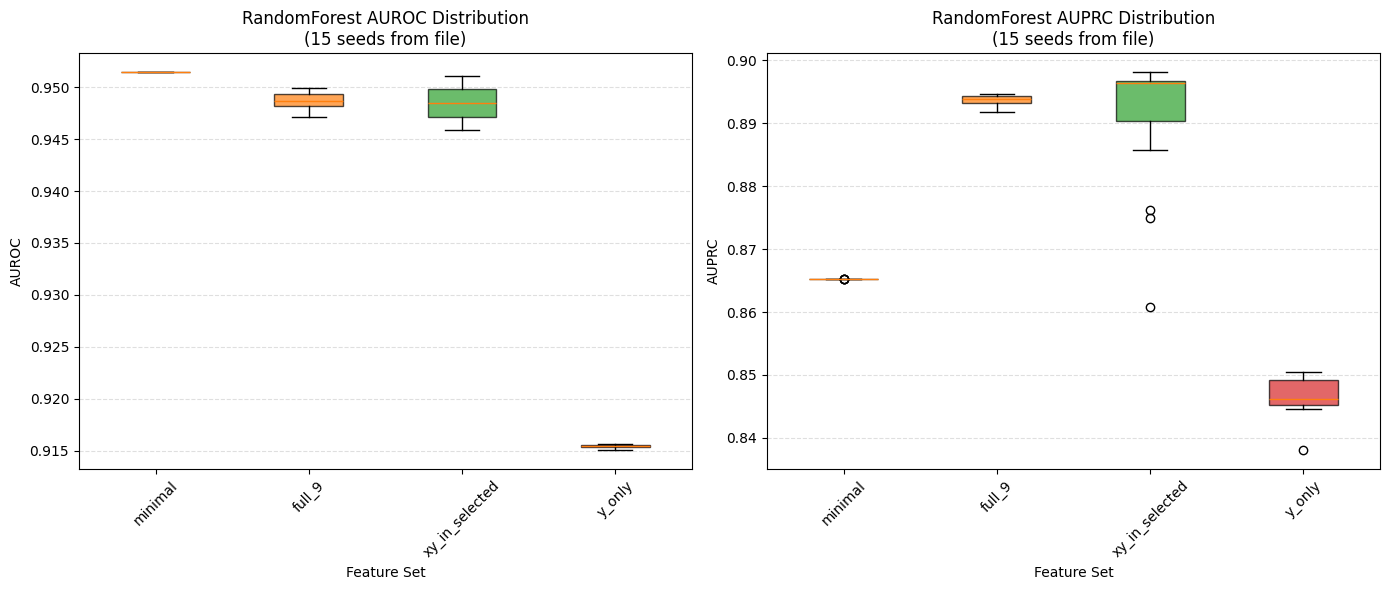

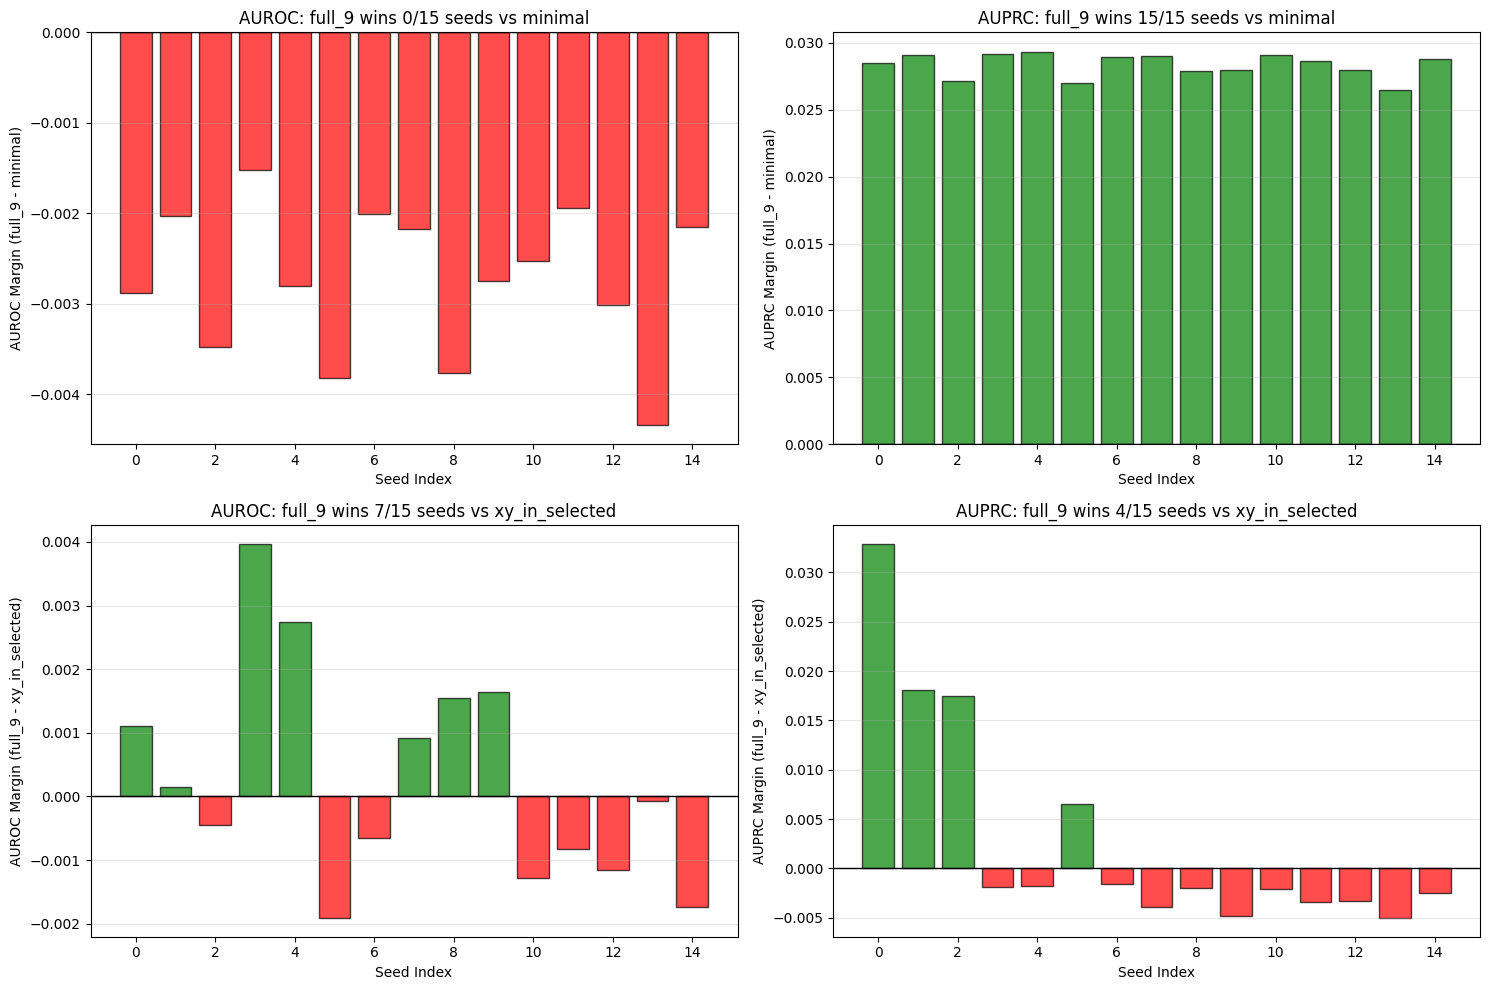

In [4]:
#!/usr/bin/env python3
"""
─────────────────────────────────────────────────────────────────────────────
Sex-prediction benchmark  –  RandomForest with 15 seeds from file
─────────────────────────────────────────────────────────────────────────────
• Training : merged MLL scRNA-seq   (mll_merged_qc.h5ad)
• Test     : kidney_unbias donor-only dataset (kidney_unbias.h5ad)
• Feature panels: minimal (4 genes), full_9, xy_in_selected, y_only
• Classifier: RandomForest with optimized parameters
• Seeds: 15 seeds from human_random_seed.txt
• Updated RF params: n_estimators=50, max_depth=None, min_samples_split=10, 
                     min_samples_leaf=2, max_features='log2', class_weight='balanced'
"""

# ═════════════════ 0) imports ═════════════════════════════════════════════
import os, warnings
import numpy as np, pandas as pd, scanpy as sc, scipy.sparse as sp
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing  import StandardScaler
from sklearn.ensemble       import RandomForestClassifier
from sklearn.metrics        import roc_auc_score, average_precision_score
from tqdm import tqdm
import time
warnings.filterwarnings("ignore", category=UserWarning)

# ═════════════════ 1) paths (relative to notebook location) ═══════════════
# Notebook is at: /Users/haley/Downloads/CellSexID-main/human.ipynb
BASE_DIR = os.path.dirname(os.path.abspath("human.ipynb"))  # /Users/haley/Downloads/CellSexID-main/

# Data paths - adjust these relative paths based on your data location
TRAIN_H5AD = os.path.join(BASE_DIR, "data/human_2/mll_merged_qc.h5ad")
KIDNEY_H5AD = os.path.join(BASE_DIR, "data/GSE151671_RAW/kidney_unbias.h5ad")

# Seeds file and output directory
SEEDS_FILE = os.path.join(BASE_DIR, "human_random_seed.txt")
OUT_DIR = os.path.join(BASE_DIR, "human_result")

os.makedirs(OUT_DIR, exist_ok=True)
print(f"Created output directory: {OUT_DIR}")

# Read seeds from file
try:
    with open(SEEDS_FILE, 'r') as f:
        content = f.read().strip()
    
    # Try to parse as Python list format first (like [7271, 8323, 770, ...])
    if content.startswith('[') and content.endswith(']'):
        import ast
        RANDOM_SEEDS = ast.literal_eval(content)
        print(f"Successfully read {len(RANDOM_SEEDS)} seeds from Python list format")
    else:
        # Try line-by-line format (one seed per line)
        lines = content.split('\n')
        RANDOM_SEEDS = [int(line.strip()) for line in lines if line.strip().isdigit()]
        print(f"Successfully read {len(RANDOM_SEEDS)} seeds from line-by-line format")
    
    # Take first 15 seeds if file has more
    RANDOM_SEEDS = RANDOM_SEEDS[:15]
    
    if len(RANDOM_SEEDS) < 15:
        print(f"Warning: Only found {len(RANDOM_SEEDS)} seeds in file, expected 15")
    
    print(f"Using {len(RANDOM_SEEDS)} seeds from {SEEDS_FILE}:")
    print(f"Seeds: {RANDOM_SEEDS}")
    
except FileNotFoundError:
    print(f"Seeds file not found: {SEEDS_FILE}")
    print("Creating default 15 random seeds...")
    np.random.seed(42)
    RANDOM_SEEDS = sorted(np.random.randint(1, 10000, size=15).tolist())
    print(f"Using default seeds: {RANDOM_SEEDS}")
except Exception as e:
    print(f"Error reading seeds file {SEEDS_FILE}: {e}")
    print("Using your provided seeds as fallback...")
    RANDOM_SEEDS = [7271, 8323, 770, 1686, 9168, 2048, 3386, 5579, 8667, 2559, 5735, 5052, 467, 6266, 190]
    print(f"Using fallback seeds: {RANDOM_SEEDS}")

# ═════════════════ 2) alias table ═════════════════════════════════════════
alias_to_official = {"EIF2S3L": "EIF2S3Y", "JARID1D": "KDM5D"}

def unify_gene_symbols(adata: sc.AnnData) -> sc.AnnData:
    rename = {g: alias_to_official[g.upper()]
              for g in adata.var_names if g.upper() in alias_to_official}
    if rename:
        adata.var_names = [rename.get(g, g) for g in adata.var_names]
    if not adata.var_names.is_unique:
        adata.var_names_make_unique()
    return adata

# ═════════════════ 3) sex label helper ════════════════════════════════════
def extract_sex_series(adata: sc.AnnData) -> pd.Series:
    for col in ("sex", "donor_sex"):
        if col in adata.obs:
            s = (adata.obs[col].astype(str)
                 .str.strip().str.lower().map({"female": 0, "male": 1}))
            if s.notna().any():
                return s.dropna().astype(int)
    raise KeyError("No usable sex column")

# ═════════════════ 4) marker panels ═══════════════════════════════════════
# Updated minimal markers to 4 genes as requested
MINIMAL_MARKERS = ["XIST", "RPS4Y1", "EIF1AY", "DDX3Y"]
FULL_MARKERS    = ["RPS4Y1", "EIF1AY", "XIST", "DDX3Y", "UTY",
                   "KDM5D", "IFIT3", "IFIT2", "RPS4X"]

# ── Y-genes (with SSL handling) ──────────────────────────────────────────
try:
    import ssl
    import urllib.request
    
    # Create SSL context that doesn't verify certificates (for problematic systems)
    ssl_context = ssl.create_default_context()
    ssl_context.check_hostname = False
    ssl_context.verify_mode = ssl.CERT_NONE
    
    HGNC_URL = ("https://storage.googleapis.com/public-download-files/"
                "hgnc/tsv/tsv/hgnc_complete_set.txt")
    
    # Try downloading with custom SSL context
    with urllib.request.urlopen(HGNC_URL, context=ssl_context) as response:
        import io
        hgnc = pd.read_csv(io.StringIO(response.read().decode('utf-8')), sep="\t", low_memory=False)
    
    mask = (hgnc["status"] == "Approved") & (hgnc["location"].str.startswith("Y", na=False))
    Y_MARKERS = sorted(hgnc.loc[mask, "symbol"].dropna().unique())
    print(f"Successfully downloaded HGNC data. Found {len(Y_MARKERS)} Y-linked genes.")
    
except Exception as e:
    print(f"Could not download HGNC data: {e}")
    print("Using fallback Y-chromosome gene list...")
    
    # Comprehensive fallback list of Y-chromosome genes
    Y_MARKERS = [
        "AMELY", "ASMTY", "BPY2", "BPY2B", "BPY2C", "CD24P4", "CDY1", "CDY1B", 
        "CDY2A", "CDY2B", "CYorf15A", "CYorf15B", "DAZ1", "DAZ2", "DAZ3", "DAZ4",
        "DBY", "DDX3Y", "EIF1AY", "FAM224A", "FAM224B", "HSFY1", "HSFY2", 
        "KDM5D", "NLGN4Y", "PCDH11Y", "PLCXD1", "PRY", "PRY2", "PRKY", "RBMY1A1",
        "RBMY1B", "RBMY1D", "RBMY1E", "RBMY1F", "RBMY1J", "RPS4Y1", "RPS4Y2",
        "SRY", "TBLIY", "TGIF2LY", "TBL1Y", "TMSB4Y", "TSPY1", "TSPY2", "TSPY3",
        "TSPY4", "TSPY8", "TTTY1", "TTTY2", "TTTY3", "TTTY4", "TTTY5", "TTTY6",
        "TTTY7", "TTTY8", "TTTY9", "TTTY10", "TTTY13", "TTTY14", "TTTY15", 
        "TTTY17", "TTTY18", "TTTY20", "TTTY21", "TTTY22", "TTTY23", "USP9Y",
        "UTY", "VCY", "VCY1B", "XKRY", "ZFY"
    ]

FEATURE_SETS = {
    "minimal": MINIMAL_MARKERS,
    "full_9":  FULL_MARKERS,
    "xy_in_selected": ["RPS4Y1", "EIF1AY", "XIST", "DDX3Y",
                       "UTY", "KDM5D", "RPS4X"],
    "y_only":  Y_MARKERS,
}

print(f"Feature sets:")
for name, genes in FEATURE_SETS.items():
    print(f"  • {name}: {len(genes)} genes")

# ═════════════════ 5) helper to build feature matrix ══════════════════════
def build_feature_df(adata: sc.AnnData, genes: list[str]) -> pd.DataFrame:
    var_up = {g.upper(): g for g in adata.var_names}
    alias_up = {k.upper(): v.upper() for k, v in alias_to_official.items()}
    found, missing = {}, []
    for g in genes:
        key = g.upper()
        if key in var_up:
            found[g] = var_up[key]
        elif key in alias_up and alias_up[key] in var_up:
            found[g] = var_up[alias_up[key]]
        else:
            missing.append(g)
    X = adata[:, list(found.values())].X if found else sp.csr_matrix((adata.n_obs, 0))
    X = X.toarray() if sp.issparse(X) else X
    df = pd.DataFrame(X, index=adata.obs_names, columns=list(found.keys()))
    for g in missing:
        df[g] = 0.0
    return df[genes]

# ═════════════════ 6) evaluation routine (RF with specified params) ═══════
def eval_feature_set_rf_optimized(genes, train_ad, y_tr, test_ad, y_te, seed):
    X_tr = build_feature_df(train_ad, genes)
    X_te = build_feature_df(test_ad, genes)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    
    # RandomForest with specified parameters
    mdl = RandomForestClassifier(
        n_estimators=50,
        max_depth=None,
        min_samples_split=10,
        min_samples_leaf=2,
        max_features='log2',
        class_weight='balanced',
        n_jobs=-1,  # Use all available CPU cores
        random_state=seed
    )
    name = type(mdl).__name__
    
    results = []
    
    # Cross-validation
    for fold_idx, (tr_idx, val_idx) in enumerate(skf.split(X_tr, y_tr)):
        sca = StandardScaler()
        Xtr = sca.fit_transform(X_tr.iloc[tr_idx])
        Xva = sca.transform(X_tr.iloc[val_idx])
        mdl.fit(Xtr, y_tr.iloc[tr_idx])
        
        # Get probabilities
        prob = mdl.predict_proba(Xva)[:, 1]
        auc = roc_auc_score(y_tr.iloc[val_idx], prob)
        prc = average_precision_score(y_tr.iloc[val_idx], prob)
        
        results.append({
            'seed': seed,
            'feature_set': genes,
            'model': name,
            'fold': fold_idx + 1,
            'type': 'cv',
            'auroc': auc,
            'auprc': prc
        })

    # Test set evaluation
    sca = StandardScaler()
    mdl.fit(sca.fit_transform(X_tr), y_tr)
    
    prob_test = mdl.predict_proba(sca.transform(X_te))[:, 1]
    auc_test = roc_auc_score(y_te, prob_test)
    prc_test = average_precision_score(y_te, prob_test)
    
    results.append({
        'seed': seed,
        'feature_set': genes,
        'model': name,
        'fold': 'test',
        'type': 'test',
        'auroc': auc_test,
        'auprc': prc_test
    })
    
    return results

# ═════════════════ 7) load training & test ════════════════════════════════
print("\nLoading data...")
print(f"Training data: {TRAIN_H5AD}")
print(f"Test data: {KIDNEY_H5AD}")

try:
    train_ad = unify_gene_symbols(sc.read_h5ad(TRAIN_H5AD))
    y_train = extract_sex_series(train_ad); train_ad = train_ad[y_train.index]

    test_ad = unify_gene_symbols(sc.read_h5ad(KIDNEY_H5AD))
    y_test  = extract_sex_series(test_ad);  test_ad  = test_ad[y_test.index]

    print(f"Train : {train_ad.n_obs:,} cells")
    print(f"Test  : {test_ad.n_obs:,} cells (♀{(y_test==0).sum()} ♂{(y_test==1).sum()})")
    
except FileNotFoundError as e:
    print(f"Error loading data files: {e}")
    print("Please check the data file paths and adjust them accordingly.")
    exit(1)

# ═════════════════ 8) evaluate all panels with optimized RF ════════════════
all_results = []
start_time = time.time()

# Initialize progress tracking
total_iterations = len(RANDOM_SEEDS) * len(FEATURE_SETS)
completed_iterations = 0

print(f"\nStarting evaluation with {len(RANDOM_SEEDS)} seeds × {len(FEATURE_SETS)} feature sets = {total_iterations} total runs")

# Progress bar for seeds with intermediate saving
for seed_idx, seed in enumerate(tqdm(RANDOM_SEEDS, desc="Random seeds", position=0)):
    seed_start_time = time.time()
    
    for fs_name, genes in FEATURE_SETS.items():
        iteration_start = time.time()
        
        # Run evaluation
        results = eval_feature_set_rf_optimized(genes, train_ad, y_train, test_ad, y_test, seed)
        
        # Update results with feature set name and gene count
        for r in results:
            r['feature_set'] = fs_name
            r['n_features'] = len(genes)
        all_results.extend(results)
        
        completed_iterations += 1
        iteration_time = time.time() - iteration_start
        
        # Print progress for current iteration
        print(f"  Completed seed {seed}, {fs_name} ({len(genes)} genes) in {iteration_time:.1f}s")
        
        # Save intermediate results every 5 iterations or after each seed
        if completed_iterations % 5 == 0 or fs_name == list(FEATURE_SETS.keys())[-1]:
            temp_df = pd.DataFrame(all_results)
            temp_csv = os.path.join(OUT_DIR, f"rf_intermediate_results_{completed_iterations}.csv")
            temp_df.to_csv(temp_csv, index=False)
    
    seed_time = time.time() - seed_start_time
    remaining_seeds = len(RANDOM_SEEDS) - seed_idx - 1
    estimated_remaining = seed_time * remaining_seeds
    
    print(f"Seed {seed} completed in {seed_time:.1f}s. "
          f"Estimated remaining time: {estimated_remaining/60:.1f} minutes")

total_time = time.time() - start_time
print(f"\n✅ All evaluations completed in {total_time/60:.1f} minutes")

# Convert to DataFrame and save ALL results (including CV)
results_df = pd.DataFrame(all_results)
csv_path = os.path.join(OUT_DIR, "rf_all_results_complete.csv")
results_df.to_csv(csv_path, index=False)
print(f"\n✅ All results (CV + test) saved → {csv_path}")

# Also save test-only results separately for convenience
test_only_df = results_df[results_df['type'] == 'test']
test_csv_path = os.path.join(OUT_DIR, "rf_test_results_only.csv")
test_only_df.to_csv(test_csv_path, index=False)
print(f"🧪 Test-only results saved → {test_csv_path}")

# Save the random seeds and RF parameters used
config_path = os.path.join(OUT_DIR, "rf_config.txt")
with open(config_path, 'w') as f:
    f.write("RANDOMFOREST CONFIGURATION\n")
    f.write("="*50 + "\n")
    f.write("n_estimators: 50\n")
    f.write("max_depth: None\n")
    f.write("min_samples_split: 10\n")
    f.write("min_samples_leaf: 2\n")
    f.write("max_features: 'log2'\n")
    f.write("class_weight: 'balanced'\n")
    f.write("n_jobs: -1\n\n")
    
    f.write("FEATURE SETS\n")
    f.write("="*50 + "\n")
    for name, genes in FEATURE_SETS.items():
        f.write(f"{name} ({len(genes)} genes): {genes[:5]}{'...' if len(genes) > 5 else ''}\n")
    
    f.write("\nRANDOM SEEDS USED\n")
    f.write("="*50 + "\n")
    f.write(f"Seeds file: {SEEDS_FILE}\n")
    for seed in RANDOM_SEEDS:
        f.write(f"{seed}\n")
        
    f.write(f"\nTotal evaluation time: {total_time/60:.1f} minutes\n")

print(f"📝 Configuration saved → {config_path}")

# ═════════════════ 9) summary statistics ══════════════════════════════════
# Create summary with mean and std across seeds for test set only
test_results = results_df[results_df['type'] == 'test']
summary = test_results.groupby(['feature_set']).agg({
    'auroc': ['mean', 'std', 'min', 'max'],
    'auprc': ['mean', 'std', 'min', 'max']
}).round(4)

summary_path = os.path.join(OUT_DIR, "rf_summary.csv")
summary.to_csv(summary_path)
print(f"📊 Summary statistics saved → {summary_path}")

# Print summary to console
print("\n" + "="*80)
print("SUMMARY STATISTICS (Test Set Performance)")
print("="*80)
for fs_name in FEATURE_SETS.keys():
    fs_data = test_results[test_results['feature_set'] == fs_name]
    auroc_mean = fs_data['auroc'].mean()
    auroc_std = fs_data['auroc'].std()
    auprc_mean = fs_data['auprc'].mean()
    auprc_std = fs_data['auprc'].std()
    
    print(f"{fs_name:15s}: AUROC {auroc_mean:.4f}±{auroc_std:.4f}, "
          f"AUPRC {auprc_mean:.4f}±{auprc_std:.4f}")

# Save detailed per-seed results for easy seed selection
seed_performance = []
for seed in RANDOM_SEEDS:
    seed_data = test_results[test_results['seed'] == seed]
    
    # Get performance for each feature set
    perf = {'seed': seed}
    for fs in FEATURE_SETS.keys():
        fs_data = seed_data[seed_data['feature_set'] == fs]
        if not fs_data.empty:
            perf[f'{fs}_auroc'] = fs_data['auroc'].values[0]
            perf[f'{fs}_auprc'] = fs_data['auprc'].values[0]
    
    # Calculate margins vs minimal (4-gene baseline)
    if 'full_9_auroc' in perf and 'minimal_auroc' in perf:
        perf['full9_vs_minimal_auroc_margin'] = perf['full_9_auroc'] - perf['minimal_auroc']
        perf['full9_vs_minimal_auprc_margin'] = perf['full_9_auprc'] - perf['minimal_auprc']
        perf['full9_wins_auroc'] = perf['full9_vs_minimal_auroc_margin'] > 0
        perf['full9_wins_auprc'] = perf['full9_vs_minimal_auprc_margin'] > 0
    
    # Calculate margins vs xy_in_selected
    if 'full_9_auroc' in perf and 'xy_in_selected_auroc' in perf:
        perf['full9_vs_xy_auroc_margin'] = perf['full_9_auroc'] - perf['xy_in_selected_auroc']
        perf['full9_vs_xy_auprc_margin'] = perf['full_9_auprc'] - perf['xy_in_selected_auprc']
    
    seed_performance.append(perf)

# Save seed performance table
seed_perf_df = pd.DataFrame(seed_performance)
seed_perf_path = os.path.join(OUT_DIR, "seed_performance_comparison.csv")
seed_perf_df.to_csv(seed_perf_path, index=False)
print(f"🌱 Per-seed performance saved → {seed_perf_path}")

# ═════════════════ 10) analysis: performance comparisons ═══════════════════
print("\n" + "="*80)
print("ANALYSIS: Feature Set Performance Comparisons")
print("="*80)

# Compare full_9 vs minimal (4-gene baseline)
wins_auroc_vs_minimal = 0
wins_auprc_vs_minimal = 0
margins_auroc_vs_minimal = []
margins_auprc_vs_minimal = []

# Compare full_9 vs xy_in_selected
wins_auroc_vs_xy = 0
wins_auprc_vs_xy = 0
margins_auroc_vs_xy = []
margins_auprc_vs_xy = []

for seed in RANDOM_SEEDS:
    seed_data = test_results[test_results['seed'] == seed]
    
    full9 = seed_data[seed_data['feature_set'] == 'full_9']
    minimal = seed_data[seed_data['feature_set'] == 'minimal']
    xy = seed_data[seed_data['feature_set'] == 'xy_in_selected']
    
    # full_9 vs minimal
    if not full9.empty and not minimal.empty:
        margin_auroc = full9['auroc'].values[0] - minimal['auroc'].values[0]
        margin_auprc = full9['auprc'].values[0] - minimal['auprc'].values[0]
        
        margins_auroc_vs_minimal.append(margin_auroc)
        margins_auprc_vs_minimal.append(margin_auprc)
        
        if margin_auroc > 0:
            wins_auroc_vs_minimal += 1
        if margin_auprc > 0:
            wins_auprc_vs_minimal += 1
    
    # full_9 vs xy_in_selected
    if not full9.empty and not xy.empty:
        margin_auroc = full9['auroc'].values[0] - xy['auroc'].values[0]
        margin_auprc = full9['auprc'].values[0] - xy['auprc'].values[0]
        
        margins_auroc_vs_xy.append(margin_auroc)
        margins_auprc_vs_xy.append(margin_auprc)
        
        if margin_auroc > 0:
            wins_auroc_vs_xy += 1
        if margin_auprc > 0:
            wins_auprc_vs_xy += 1

print(f"\nfull_9 vs minimal (4 genes) - out of {len(RANDOM_SEEDS)} seeds:")
print(f"  AUROC: full_9 wins {wins_auroc_vs_minimal} times ({wins_auroc_vs_minimal/len(RANDOM_SEEDS)*100:.1f}%)")
print(f"  AUPRC: full_9 wins {wins_auprc_vs_minimal} times ({wins_auprc_vs_minimal/len(RANDOM_SEEDS)*100:.1f}%)")
print(f"  Average AUROC margin: {np.mean(margins_auroc_vs_minimal):.6f}")
print(f"  Average AUPRC margin: {np.mean(margins_auprc_vs_minimal):.6f}")

print(f"\nfull_9 vs xy_in_selected - out of {len(RANDOM_SEEDS)} seeds:")
print(f"  AUROC: full_9 wins {wins_auroc_vs_xy} times ({wins_auroc_vs_xy/len(RANDOM_SEEDS)*100:.1f}%)")
print(f"  AUPRC: full_9 wins {wins_auprc_vs_xy} times ({wins_auprc_vs_xy/len(RANDOM_SEEDS)*100:.1f}%)")
print(f"  Average AUROC margin: {np.mean(margins_auroc_vs_xy):.6f}")
print(f"  Average AUPRC margin: {np.mean(margins_auprc_vs_xy):.6f}")

# ═════════════════ 11) visualization ══════════════════════════════════════
# Create visualization for optimized RF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Box plot for AUROC
feature_order = list(FEATURE_SETS.keys())
auroc_data = [test_results[test_results['feature_set'] == fs]['auroc'].values 
              for fs in feature_order]
colors = plt.cm.tab10(np.arange(len(feature_order)))

bp1 = ax1.boxplot(auroc_data, labels=feature_order, patch_artist=True)
for patch, color in zip(bp1['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax1.set_title(f'RandomForest AUROC Distribution\n({len(RANDOM_SEEDS)} seeds from file)')
ax1.set_ylabel('AUROC')
ax1.set_xlabel('Feature Set')
ax1.grid(axis='y', linestyle='--', alpha=0.4)
ax1.set_xticklabels(feature_order, rotation=45)

# Box plot for AUPRC
auprc_data = [test_results[test_results['feature_set'] == fs]['auprc'].values 
              for fs in feature_order]

bp2 = ax2.boxplot(auprc_data, labels=feature_order, patch_artist=True)
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax2.set_title(f'RandomForest AUPRC Distribution\n({len(RANDOM_SEEDS)} seeds from file)')
ax2.set_ylabel('AUPRC')
ax2.set_xlabel('Feature Set')
ax2.grid(axis='y', linestyle='--', alpha=0.4)
ax2.set_xticklabels(feature_order, rotation=45)

plt.tight_layout()
png_path = os.path.join(OUT_DIR, "rf_distribution.png")
plt.savefig(png_path, dpi=300, bbox_inches='tight')
print(f"\n📈 Distribution plot saved → {png_path}")

# ═════════════════ 12) margin distribution plots ══════════════════════════
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# AUROC margins vs minimal
colors_auroc_min = ['green' if m > 0 else 'red' for m in margins_auroc_vs_minimal]
ax1.bar(range(len(margins_auroc_vs_minimal)), margins_auroc_vs_minimal, 
        color=colors_auroc_min, alpha=0.7, edgecolor='black')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax1.set_xlabel('Seed Index')
ax1.set_ylabel('AUROC Margin (full_9 - minimal)')
ax1.set_title(f'AUROC: full_9 wins {wins_auroc_vs_minimal}/{len(margins_auroc_vs_minimal)} seeds vs minimal')
ax1.grid(axis='y', alpha=0.3)

# AUPRC margins vs minimal
colors_auprc_min = ['green' if m > 0 else 'red' for m in margins_auprc_vs_minimal]
ax2.bar(range(len(margins_auprc_vs_minimal)), margins_auprc_vs_minimal, 
        color=colors_auprc_min, alpha=0.7, edgecolor='black')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.set_xlabel('Seed Index')
ax2.set_ylabel('AUPRC Margin (full_9 - minimal)')
ax2.set_title(f'AUPRC: full_9 wins {wins_auprc_vs_minimal}/{len(margins_auprc_vs_minimal)} seeds vs minimal')
ax2.grid(axis='y', alpha=0.3)

# AUROC margins vs xy_in_selected
colors_auroc_xy = ['green' if m > 0 else 'red' for m in margins_auroc_vs_xy]
ax3.bar(range(len(margins_auroc_vs_xy)), margins_auroc_vs_xy, 
        color=colors_auroc_xy, alpha=0.7, edgecolor='black')
ax3.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax3.set_xlabel('Seed Index')
ax3.set_ylabel('AUROC Margin (full_9 - xy_in_selected)')
ax3.set_title(f'AUROC: full_9 wins {wins_auroc_vs_xy}/{len(margins_auroc_vs_xy)} seeds vs xy_in_selected')
ax3.grid(axis='y', alpha=0.3)

# AUPRC margins vs xy_in_selected
colors_auprc_xy = ['green' if m > 0 else 'red' for m in margins_auprc_vs_xy]
ax4.bar(range(len(margins_auprc_vs_xy)), margins_auprc_vs_xy, 
        color=colors_auprc_xy, alpha=0.7, edgecolor='black')
ax4.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax4.set_xlabel('Seed Index')
ax4.set_ylabel('AUPRC Margin (full_9 - xy_in_selected)')
ax4.set_title(f'AUPRC: full_9 wins {wins_auprc_vs_xy}/{len(margins_auprc_vs_xy)} seeds vs xy_in_selected')
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
margin_png_path = os.path.join(OUT_DIR, "rf_margins.png")
plt.savefig(margin_png_path, dpi=300, bbox_inches='tight')
print(f"📊 Margin analysis plot saved → {margin_png_path}")

# ═════════════════ 13) final summary ══════════════════════════════════════
print("\n✅ Analysis complete!")
print(f"\n⏱️  Total runtime: {total_time/60:.1f} minutes")
print(f"📁 All files saved to: {OUT_DIR}")
print("\nFiles created:")
print(f"   • Complete results (CV+test): rf_all_results_complete.csv")
print(f"   • Test-only results: rf_test_results_only.csv")
print(f"   • Seed performance comparison: seed_performance_comparison.csv")
print(f"   • Summary statistics: rf_summary.csv")
print(f"   • Configuration & seeds: rf_config.txt")
print(f"   • Distribution plots: rf_distribution.png")
print(f"   • Margin analysis plots: rf_margins.png")

print(f"\n🔬 Key findings:")
print(f"   • Minimal (4 genes): {MINIMAL_MARKERS}")
print(f"   • RF parameters: n_estimators=50, balanced classes, log2 features")
print(f"   • {len(RANDOM_SEEDS)} seeds from: {SEEDS_FILE}")
print(f"   • full_9 vs minimal: {wins_auroc_vs_minimal}/{len(RANDOM_SEEDS)} AUROC wins, {wins_auprc_vs_minimal}/{len(RANDOM_SEEDS)} AUPRC wins")
print(f"   • full_9 vs xy_selected: {wins_auroc_vs_xy}/{len(RANDOM_SEEDS)} AUROC wins, {wins_auprc_vs_xy}/{len(RANDOM_SEEDS)} AUPRC wins")

print("\n💡 Use seed_performance_comparison.csv to select the best seeds for your analysis!")

In [17]:
import pandas as pd

HGNC_URL = (
    "https://storage.googleapis.com/"
    "public-download-files/hgnc/tsv/tsv/hgnc_complete_set.txt"
)

hgnc = pd.read_csv(HGNC_URL, sep="\t", low_memory=False)

# — fix: parentheses around each condition —
mask = (
    (hgnc["status"] == "Approved")                       # keep only approved symbols
    & (hgnc["location"].str.startswith("Y", na=False))   # chr-Y loci
)

y_genes = (
    hgnc.loc[mask, "symbol"]
        .dropna()
        .unique()
        .tolist()
)

print(f"{len(y_genes)} HGNC-approved genes on chr Y")
print(sorted(y_genes)[:10], "…")


485 HGNC-approved genes on chr Y
['ACTG1P11', 'ACTG1P2', 'ACTR3BP1', 'AGKP1', 'AGPAT5P1', 'AMELY', 'ANKRD20A6P', 'ANKRD36P1', 'ANOS2P', 'ARSDP1'] …


data2 self


In [ ]:
#!/usr/bin/env python3
"""
─────────────────────────────────────────────────────────────────────────────
Sex-prediction benchmark  –  80/20 train/test split from single dataset
─────────────────────────────────────────────────────────────────────────────
• Data source: merged MLL scRNA-seq (mll_merged_qc.h5ad)
• Split: 80% train, 20% test (random_state=42)
• Feature panels: minimal, full_9, xy_in_selected, y_only, x_plus_y
• Classifiers: Logistic, SVC, XGB, RandomForest

Outputs:
  sex_prediction_results_final.csv (all results)
  sex_prediction_results_<feature_set>.csv (individual results)
  sex_prediction_plot.png
  marker_availability_summary.csv
  feature_set_comparison.csv
"""

# ═════════════════ 0) imports ═════════════════════════════════════════════
import os, warnings
import numpy as np, pandas as pd, scanpy as sc, scipy.sparse as sp
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing  import StandardScaler
from sklearn.linear_model   import LogisticRegression
from sklearn.svm            import SVC
from sklearn.ensemble       import RandomForestClassifier
from sklearn.metrics        import roc_auc_score, average_precision_score
from xgboost                import XGBClassifier
warnings.filterwarnings("ignore", category=UserWarning)

# ═════════════════ 1) paths ═══════════════════════════════════════════════
TRAIN_H5AD   = "/Users/haley/Desktop/send_tooo/human_2/mll_merged_qc.h5ad"
OUT_DIR      = "/Users/haley/Desktop/send_tooo/AAA_final/human_2self_supp"
os.makedirs(OUT_DIR, exist_ok=True)

# ═════════════════ 2) alias table ═════════════════════════════════════════
alias_to_official = {"EIF2S3L": "EIF2S3Y", "JARID1D": "KDM5D"}

def unify_gene_symbols(adata: sc.AnnData) -> sc.AnnData:
    rename = {g: alias_to_official[g.upper()]
              for g in adata.var_names if g.upper() in alias_to_official}
    if rename:
        adata.var_names = [rename.get(g, g) for g in adata.var_names]
    if not adata.var_names.is_unique:
        adata.var_names_make_unique()
    return adata

# ═════════════════ 3) sex label helper ════════════════════════════════════
def extract_sex_series(adata: sc.AnnData) -> pd.Series:
    for col in ("sex", "donor_sex"):
        if col in adata.obs:
            s = (adata.obs[col].astype(str)
                 .str.strip().str.lower().map({"female": 0, "male": 1}))
            if s.notna().any():
                return s.dropna().astype(int)
    raise KeyError("No usable sex column")

# ═════════════════ 4) marker panels ═══════════════════════════════════════
MINIMAL_MARKERS = ["XIST", "RPS4Y1"]
FULL_MARKERS    = ["RPS4Y1", "EIF1AY", "XIST", "DDX3Y", "UTY",
                   "KDM5D", "IFIT3", "IFIT2", "RPS4X"]

X_MARKERS = ["XIST", "RPS4X", "DDX3X", "KDM5C", "KDM6A", "EIF2S3X", "USP9X", "ZFX", "PCDH11X"]
#  ["XIST", "TSIX", "JPX", "FTX", "KDM6A", "KDM5C", "DDX3X", "RPS4X",
#              "EIF2S3X", "EIF1AX", "USP9X", "ZFX", "SMC1A", "RPL10", "RPL36A",
#              "NR0B1", "RPS6KA3", "MECP2", "FMR1", "NLGN4X", "AR", "G6PD",
#              "MAOA", "OTC", "ACE2", "CYBB", "DMD", "BCOR", "HUWE1", "IKBKG",
#              "HDAC6", "FOXP3", "PHKA2", "IDS", "EDA", "MSL3", "MED14"]

# ── live HGNC Y-genes ─────────────────────────────────────────────────────
HGNC_URL = ("https://storage.googleapis.com/public-download-files/"
            "hgnc/tsv/tsv/hgnc_complete_set.txt")
hgnc = pd.read_csv(HGNC_URL, sep="\t", low_memory=False)
mask = (hgnc["status"] == "Approved") & (hgnc["location"].str.startswith("Y", na=False))
Y_MARKERS = sorted(hgnc.loc[mask, "symbol"].dropna().unique())
XY_MARKERS = sorted(set(X_MARKERS) | set(Y_MARKERS))

FEATURE_SETS = {
    "minimal": MINIMAL_MARKERS,
    "full_9":  FULL_MARKERS,
    "xy_in_selected": ["RPS4Y1", "EIF1AY", "XIST", "DDX3Y",
                       "UTY", "KDM5D", "RPS4X"],
    "y_only":  Y_MARKERS,
    "x_plus_y": XY_MARKERS,
}

# ═════════════════ 5) helper to find available genes ══════════════════════
def find_available_genes(adata: sc.AnnData, genes: list[str]) -> tuple[list[str], list[str]]:
    """
    Find genes that exist in the dataset, accounting for aliases.
    Returns: (available_genes, missing_genes)
    """
    var_up = {g.upper(): g for g in adata.var_names}
    alias_up = {k.upper(): v.upper() for k, v in alias_to_official.items()}
    found = {}
    
    for g in genes:
        key = g.upper()
        if key in var_up:
            found[g] = var_up[key]
        elif key in alias_up and alias_up[key] in var_up:
            found[g] = var_up[alias_up[key]]
    
    available_genes = [g for g in genes if g in found]
    missing_genes = [g for g in genes if g not in found]
    
    return available_genes, missing_genes

# ═════════════════ 6) helper to build feature matrix ══════════════════════
def build_feature_df(adata: sc.AnnData, genes: list[str]) -> pd.DataFrame:
    """Build feature matrix only for genes that exist in the dataset."""
    var_up = {g.upper(): g for g in adata.var_names}
    alias_up = {k.upper(): v.upper() for k, v in alias_to_official.items()}
    found = {}
    
    for g in genes:
        key = g.upper()
        if key in var_up:
            found[g] = var_up[key]
        elif key in alias_up and alias_up[key] in var_up:
            found[g] = var_up[alias_up[key]]
    
    if not found:
        # Return empty dataframe if no genes found
        return pd.DataFrame(index=adata.obs_names)
    
    X = adata[:, list(found.values())].X
    X = X.toarray() if sp.issparse(X) else X
    df = pd.DataFrame(X, index=adata.obs_names, columns=list(found.keys()))
    
    # Return only the genes in the original order that were found
    return df[[g for g in genes if g in found]]

# ═════════════════ 7) evaluation routine ══════════════════════════════════
def eval_feature_set(genes, train_ad, y_train, test_ad, y_test):
    """Evaluate feature set using available genes."""
    available_genes, missing_genes = find_available_genes(train_ad, genes)
    
    if not available_genes:
        print(f"    ⚠️  No genes found for this feature set!")
        return {}, available_genes, missing_genes
    
    print(f"    Using {len(available_genes)}/{len(genes)} available genes")
    if missing_genes:
        print(f"    Missing genes: {missing_genes}")
    
    X_train = build_feature_df(train_ad, available_genes)
    X_test = build_feature_df(test_ad, available_genes)
    
    if X_train.empty or X_test.empty:
        print(f"    ⚠️  Empty feature matrix!")
        return {}, available_genes, missing_genes

    # 5-fold cross-validation on training set
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    models = [
        LogisticRegression(max_iter=1000, random_state=42),
        SVC(kernel="linear", probability=True, random_state=42),
        XGBClassifier(eval_metric="logloss", n_estimators=100,
                      learning_rate=0.05, max_depth=10, use_label_encoder=False,
                      random_state=42),
        RandomForestClassifier(max_depth=10, n_estimators=200, n_jobs=-1,
                              random_state=42),
    ]

    out = {}
    for mdl in models:
        name = type(mdl).__name__
        auc_cv, prc_cv = [], []
        
        # Cross-validation on training set
        for tr_idx, val_idx in skf.split(X_train, y_train):
            sca = StandardScaler()
            Xtr = sca.fit_transform(X_train.iloc[tr_idx])
            Xva = sca.transform(X_train.iloc[val_idx])
            mdl.fit(Xtr, y_train.iloc[tr_idx])
            prob = (mdl.predict_proba(Xva)[:, 1] if hasattr(mdl, "predict_proba")
                    else mdl.decision_function(Xva))
            auc_cv.append(roc_auc_score(y_train.iloc[val_idx], prob))
            prc_cv.append(average_precision_score(y_train.iloc[val_idx], prob))

        # Final evaluation on test set
        sca = StandardScaler()
        mdl.fit(sca.fit_transform(X_train), y_train)
        prob = (mdl.predict_proba(sca.transform(X_test))[:, 1]
                if hasattr(mdl, "predict_proba")
                else mdl.decision_function(sca.transform(X_test)))

        out[name] = {
            "AUROC_CV_mean": np.mean(auc_cv), "AUROC_CV_std": np.std(auc_cv),
            "AUPRC_CV_mean": np.mean(prc_cv), "AUPRC_CV_std": np.std(prc_cv),
            "AUROC_test": roc_auc_score(y_test, prob),
            "AUPRC_test": average_precision_score(y_test, prob),
        }
    
    return out, available_genes, missing_genes

# ═════════════════ 8) load and split data ═════════════════════════════════
print("Loading and splitting dataset...")
full_adata = unify_gene_symbols(sc.read_h5ad(TRAIN_H5AD))
y_full = extract_sex_series(full_adata)
full_adata = full_adata[y_full.index]

print(f"Total dataset: {full_adata.n_obs:,} cells (♀{(y_full==0).sum()} ♂{(y_full==1).sum()})")

# Split into 80% train, 20% test with random_state=42
train_idx, test_idx = train_test_split(
    np.arange(len(y_full)), 
    test_size=0.2, 
    random_state=42, 
    stratify=y_full
)

# Create train and test datasets
train_ad = full_adata[train_idx].copy()
test_ad = full_adata[test_idx].copy()
y_train = y_full.iloc[train_idx]
y_test = y_full.iloc[test_idx]

print(f"Train split: {train_ad.n_obs:,} cells (♀{(y_train==0).sum()} ♂{(y_train==1).sum()})")
print(f"Test split:  {test_ad.n_obs:,} cells (♀{(y_test==0).sum()} ♂{(y_test==1).sum()})")

# ═════════════════ 9) evaluate all feature sets ═══════════════════════════
all_rows = []
marker_summary = []
feature_comparison = []

for fs_name, genes in FEATURE_SETS.items():
    print(f"\n▶ Feature set: {fs_name} (n={len(genes)})")
    
    res, available_genes, missing_genes = eval_feature_set(
        genes, train_ad, y_train, test_ad, y_test
    )
    
    # Store marker availability info
    marker_summary.append({
        "FeatureSet": fs_name,
        "Total_markers": len(genes),
        "Available_markers": len(available_genes),
        "Missing_markers": len(missing_genes),
        "Availability_rate": len(available_genes) / len(genes) if genes else 0,
        "Available_marker_list": "; ".join(available_genes),
        "Missing_marker_list": "; ".join(missing_genes)
    })
    
    if not res:
        print(f"    ⚠️  Skipping {fs_name} due to insufficient data")
        continue
    
    # Prepare results for this feature set
    fs_rows = []
    for mdl, met in res.items():
        row_data = dict(
            FeatureSet=fs_name,
            Model=mdl.replace("Classifier","").replace("Regression",""),
            Genes_used=len(available_genes),
            Genes_total=len(genes),
            **met
        )
        fs_rows.append(row_data)
        all_rows.append(row_data)
    
    # Feature set comparison summary
    if res:
        best_model_auroc = max(res.values(), key=lambda x: x['AUROC_test'])
        best_model_name = [k for k, v in res.items() if v['AUROC_test'] == best_model_auroc['AUROC_test']][0]
        
        feature_comparison.append({
            "FeatureSet": fs_name,
            "Genes_available": len(available_genes),
            "Genes_total": len(genes),
            "Best_model": best_model_name,
            "Best_AUROC_test": best_model_auroc['AUROC_test'],
            "Best_AUPRC_test": best_model_auroc['AUPRC_test'],
            "Best_AUROC_CV": best_model_auroc['AUROC_CV_mean'],
            "Best_AUPRC_CV": best_model_auroc['AUPRC_CV_mean']
        })
    
    # Save individual feature set results
    if fs_rows:
        fs_df = pd.DataFrame(fs_rows)
        fs_csv_path = os.path.join(OUT_DIR, f"sex_prediction_results_{fs_name}.csv")
        fs_df.to_csv(fs_csv_path, index=False)
        print(f"    ✅ Individual results saved → {fs_csv_path}")

# Save marker availability summary
marker_df = pd.DataFrame(marker_summary)
marker_csv_path = os.path.join(OUT_DIR, "marker_availability_summary.csv")
marker_df.to_csv(marker_csv_path, index=False)
print(f"\n📋 Marker availability summary → {marker_csv_path}")

# Save feature set comparison
if feature_comparison:
    comparison_df = pd.DataFrame(feature_comparison).sort_values('Best_AUROC_test', ascending=False)
    comparison_csv_path = os.path.join(OUT_DIR, "feature_set_comparison.csv")
    comparison_df.to_csv(comparison_csv_path, index=False)
    print(f"🔍 Feature set comparison → {comparison_csv_path}")

# Save final combined results
if all_rows:
    results_df = pd.DataFrame(all_rows)
    csv_path = os.path.join(OUT_DIR, "sex_prediction_results_final.csv")
    results_df.to_csv(csv_path, index=False)
    print(f"✅ Final combined results saved → {csv_path}")

    # ═════════════════ 10) visualization ═══════════════════════════════════
    models_order  = ["Logistic", "SVC", "XGB", "RandomForest"]
    feature_order = [fs for fs in FEATURE_SETS.keys() if fs in results_df["FeatureSet"].values]
    
    if len(feature_order) > 0:
        # Main comparison plot
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        width, base = 0.15, np.arange(len(models_order))

        # Test performance plots
        for i, feat in enumerate(feature_order):
            sub = results_df[results_df["FeatureSet"] == feat]
            if not sub.empty:
                colour = plt.cm.tab10(i)
                axes[0,0].bar(base + i*width,
                            sub.set_index("Model")["AUROC_test"].reindex(models_order),
                            width, color=colour, label=feat)
                axes[0,1].bar(base + i*width,
                            sub.set_index("Model")["AUPRC_test"].reindex(models_order),
                            width, color=colour)

        axes[0,0].set_title("Test AUROC"); axes[0,1].set_title("Test AUPRC")
        
        # CV performance plots
        for i, feat in enumerate(feature_order):
            sub = results_df[results_df["FeatureSet"] == feat]
            if not sub.empty:
                colour = plt.cm.tab10(i)
                axes[1,0].bar(base + i*width,
                            sub.set_index("Model")["AUROC_CV_mean"].reindex(models_order),
                            width, color=colour, label=feat)
                axes[1,1].bar(base + i*width,
                            sub.set_index("Model")["AUPRC_CV_mean"].reindex(models_order),
                            width, color=colour)

        axes[1,0].set_title("CV AUROC (mean)"); axes[1,1].set_title("CV AUPRC (mean)")
        
        for ax in axes.flat:
            ax.set_xticks(base + width*len(feature_order)/2 - width/2)
            ax.set_xticklabels(models_order, rotation=45)
            ax.set_ylabel("Score")
            ax.grid(axis="y", linestyle="--", alpha=0.4)
            ax.set_ylim(0, 1)

        axes[0,0].legend(title="Feature set", bbox_to_anchor=(1.02, 1), loc="upper left")
        plt.tight_layout()
        png_path = os.path.join(OUT_DIR, "sex_prediction_plot.png")
        plt.savefig(png_path, dpi=300, bbox_inches='tight')
        print(f"📈 Plot saved → {png_path}")
        
        # Feature set comparison summary plot
        if feature_comparison:
            plt.figure(figsize=(12, 8))
            comparison_df = pd.DataFrame(feature_comparison).sort_values('Best_AUROC_test')
            
            x_pos = np.arange(len(comparison_df))
            plt.barh(x_pos, comparison_df['Best_AUROC_test'], alpha=0.7, label='AUROC')
            plt.barh(x_pos, comparison_df['Best_AUPRC_test'], alpha=0.7, label='AUPRC')
            
            plt.yticks(x_pos, comparison_df['FeatureSet'])
            plt.xlabel('Performance Score')
            plt.title('Best Performance by Feature Set (Test Set)')
            plt.legend()
            plt.grid(axis='x', alpha=0.3)
            
            for i, (auroc, auprc, genes) in enumerate(zip(comparison_df['Best_AUROC_test'], 
                                                         comparison_df['Best_AUPRC_test'],
                                                         comparison_df['Genes_available'])):
                plt.text(max(auroc, auprc) + 0.01, i, f'n={genes}', va='center', fontsize=9)
            
            plt.tight_layout()
            summary_png_path = os.path.join(OUT_DIR, "feature_set_comparison_plot.png")
            plt.savefig(summary_png_path, dpi=300, bbox_inches='tight')
            print(f"📊 Feature set comparison plot → {summary_png_path}")
            
    else:
        print("⚠️  No valid feature sets found for plotting")
else:
    print("⚠️  No results to save - all feature sets failed")

# ═════════════════ 11) Summary statistics ═════════════════════════════════
if all_rows:
    print(f"\n🎯 SUMMARY:")
    print(f"   Dataset split: {len(y_train)} train / {len(y_test)} test (80/20)")
    print(f"   Random seed: 42")
    print(f"   Feature sets evaluated: {len(feature_order)}")
    print(f"   Models compared: {len(models_order)}")
    
    if feature_comparison:
        best_overall = max(feature_comparison, key=lambda x: x['Best_AUROC_test'])
        print(f"   Best performing feature set: {best_overall['FeatureSet']} "
              f"(AUROC: {best_overall['Best_AUROC_test']:.3f}, "
              f"Model: {best_overall['Best_model']})")

print(f"\n🎯 All outputs saved to: {OUT_DIR}")

Using 14 CPU cores
Loading dataset...
Total dataset: 87,171 cells (♀44716 ♂42455)
📋 Marker availability summary → /Users/haley/Desktop/send_tooo/AAA_final/human_2self_supp/marker_availability_summary.csv

🔄 Running experiments across 15 seeds using 14 CPU cores...
  Running seed 54...
  Running seed 53...
  Running seed 50...
  Running seed 48...
  Running seed 49...
  Running seed 46...
  Running seed 51...
  Running seed 42...
  Running seed 55...
  Running seed 52...
  Running seed 45...
  Running seed 47...
  Running seed 44...
  Running seed 43...


/Users/haley/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [12:12:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/haley/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [12:12:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/haley/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [12:12:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/haley/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [12:12:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

KeyboardInterrupt: 

In [1]:
#!/usr/bin/env python3
"""
─────────────────────────────────────────────────────────────────────────────
Visualization from Existing Results
─────────────────────────────────────────────────────────────────────────────
Reads existing CSV results and creates comparison visualizations
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ═════════════════ Configuration ═══════════════════════════════════════════
# Exact paths based on your directory structure
RESULTS_DIR = "/Users/haley/Desktop/send_tooo/AAA_final/human_2self_supp"
XY_RESULTS_DIR = "/Users/haley/Desktop/send_tooo/AAA_final/human_2self_supp/xy_only"
OUTPUT_DIR = "/Users/haley/Desktop/send_tooo/AAA_final/human_2self_supp/combined_viz"

# Files that should exist:
# RESULTS_DIR/sex_prediction_results_final.csv
# RESULTS_DIR/feature_set_comparison.csv  
# XY_RESULTS_DIR/xy_markers_detailed_results.csv

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ═════════════════ 1) Load existing results ════════════════════════════════
print("📁 Loading existing results...")
print(f"   Main results dir: {RESULTS_DIR}")
print(f"   XY results dir: {XY_RESULTS_DIR}")

# Load main comparison results
main_results_path = os.path.join(RESULTS_DIR, "sex_prediction_results_final.csv")
if os.path.exists(main_results_path):
    main_results = pd.read_csv(main_results_path)
    print(f"✅ Loaded main results: {len(main_results)} rows")
    print(f"   Feature sets: {main_results['FeatureSet'].unique()}")
    print(f"   Models: {main_results['Model'].unique()}")
else:
    print(f"❌ Main results not found at: {main_results_path}")
    exit(1)

# Load XY-only results if available
xy_results_path = os.path.join(XY_RESULTS_DIR, "xy_markers_detailed_results.csv")
xy_results = None
if os.path.exists(xy_results_path):
    xy_results = pd.read_csv(xy_results_path)
    print(f"✅ Loaded XY-only results: {len(xy_results)} rows")
    print(f"   Columns: {list(xy_results.columns)}")
else:
    print(f"⚠️  XY-only results not found at: {xy_results_path}")

# Load feature comparison if available
comparison_path = os.path.join(RESULTS_DIR, "feature_set_comparison.csv")
feature_comparison = None
if os.path.exists(comparison_path):
    feature_comparison = pd.read_csv(comparison_path)
    print(f"✅ Loaded feature comparison: {len(feature_comparison)} rows")
    print(f"   Feature sets ranked: {list(feature_comparison['FeatureSet'])}")
else:
    print(f"⚠️  Feature comparison not found at: {comparison_path}")

# ═════════════════ 2) Create main comparison visualization ══════════════════
def create_main_comparison_plot(results_df, output_dir):
    """Create the main 2x2 comparison plot like the original."""
    
    models_order = ["Logistic", "SVC", "XGB", "RandomForest"]
    feature_order = results_df["FeatureSet"].unique()
    
    print(f"📊 Creating comparison plot for {len(feature_order)} feature sets")
    
    # Create the 2x2 subplot
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    width, base = 0.15, np.arange(len(models_order))
    
    # Color scheme
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    
    # Test performance plots
    for i, feat in enumerate(feature_order):
        sub = results_df[results_df["FeatureSet"] == feat]
        if not sub.empty:
            color = colors[i] if i < len(colors) else plt.cm.tab10(i)
            
            # Test AUROC
            axes[0,0].bar(base + i*width,
                        sub.set_index("Model")["AUROC_test"].reindex(models_order),
                        width, color=color, label=feat, alpha=0.8)
            # Test AUPRC  
            axes[0,1].bar(base + i*width,
                        sub.set_index("Model")["AUPRC_test"].reindex(models_order),
                        width, color=color, alpha=0.8)

    axes[0,0].set_title("Test AUROC", fontsize=14, fontweight='bold')
    axes[0,1].set_title("Test AUPRC", fontsize=14, fontweight='bold')
    
    # CV performance plots
    for i, feat in enumerate(feature_order):
        sub = results_df[results_df["FeatureSet"] == feat]
        if not sub.empty:
            color = colors[i] if i < len(colors) else plt.cm.tab10(i)
            
            # CV AUROC
            axes[1,0].bar(base + i*width,
                        sub.set_index("Model")["AUROC_CV_mean"].reindex(models_order),
                        width, color=color, alpha=0.8)
            # CV AUPRC
            axes[1,1].bar(base + i*width,
                        sub.set_index("Model")["AUPRC_CV_mean"].reindex(models_order),
                        width, color=color, alpha=0.8)

    axes[1,0].set_title("CV AUROC (mean)", fontsize=14, fontweight='bold')
    axes[1,1].set_title("CV AUPRC (mean)", fontsize=14, fontweight='bold')
    
    # Format all axes
    for ax in axes.flat:
        ax.set_xticks(base + width*len(feature_order)/2 - width/2)
        ax.set_xticklabels(models_order, rotation=45)
        ax.set_ylabel("Score", fontsize=12)
        ax.grid(axis="y", linestyle="--", alpha=0.4)
        ax.set_ylim(0, 1)

    # Add legend
    axes[0,0].legend(title="Feature set", bbox_to_anchor=(1.02, 1), loc="upper left")
    
    # Add title
    fig.suptitle('Sex Prediction Performance Comparison\n(With Updated X+Y Markers)', 
                fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plot_path = os.path.join(output_dir, "combined_performance_comparison.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"📈 Main comparison plot saved → {plot_path}")

# ═════════════════ 3) Create feature set ranking plot ══════════════════════
def create_ranking_plot(feature_comparison_df, output_dir):
    """Create horizontal bar chart ranking feature sets."""
    
    if feature_comparison_df is None:
        print("⚠️  No feature comparison data available")
        return
    
    plt.figure(figsize=(12, 8))
    
    # Sort by best AUROC
    df_sorted = feature_comparison_df.sort_values('Best_AUROC_test')
    
    x_pos = np.arange(len(df_sorted))
    
    # Create bars
    bars1 = plt.barh(x_pos, df_sorted['Best_AUROC_test'], alpha=0.8, 
                   label='AUROC', color='#2E86AB', height=0.35)
    bars2 = plt.barh(x_pos + 0.35, df_sorted['Best_AUPRC_test'], alpha=0.8, 
                   label='AUPRC', color='#A23B72', height=0.35)
    
    plt.yticks(x_pos + 0.175, df_sorted['FeatureSet'])
    plt.xlabel('Performance Score', fontsize=12)
    plt.title('Best Performance by Feature Set\n(Updated X+Y Markers)', 
             fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(axis='x', alpha=0.3)
    
    # Add gene count annotations
    for i, (auroc, auprc, genes) in enumerate(zip(df_sorted['Best_AUROC_test'], 
                                                 df_sorted['Best_AUPRC_test'],
                                                 df_sorted['Genes_available'])):
        plt.text(max(auroc, auprc) + 0.01, i + 0.175, f'n={genes}', 
                va='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    ranking_path = os.path.join(output_dir, "feature_set_ranking.png")
    plt.savefig(ranking_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"📊 Feature set ranking plot saved → {ranking_path}")

# ═════════════════ 4) Create detailed XY analysis plot ═════════════════════
def create_xy_detailed_plot(xy_results_df, output_dir):
    """Create detailed plot for XY markers only."""
    
    if xy_results_df is None:
        print("⚠️  No XY-only results available")
        return
    
    # Prepare data
    metrics = ['AUROC_test', 'AUPRC_test', 'Accuracy_test', 'Sensitivity', 'Specificity']
    models = xy_results_df['Model'].tolist()
    
    # Create subplot
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # Plot each metric
    for i, metric in enumerate(metrics):
        if metric in xy_results_df.columns:
            values = xy_results_df[metric].tolist()
            bars = axes[i].bar(models, values, alpha=0.7, 
                              color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
            
            axes[i].set_title(f'{metric.replace("_", " ").title()}', fontsize=12, fontweight='bold')
            axes[i].set_ylabel('Score')
            axes[i].set_ylim(0, 1)
            axes[i].grid(axis='y', alpha=0.3)
            
            # Add value labels
            for bar, val in zip(bars, values):
                axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                            f'{val:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # CV comparison if available
    if 'AUROC_CV_mean' in xy_results_df.columns:
        cv_auroc = xy_results_df['AUROC_CV_mean'].tolist()
        cv_std = xy_results_df['AUROC_CV_std'].tolist() if 'AUROC_CV_std' in xy_results_df.columns else [0]*len(cv_auroc)
        
        axes[5].bar(models, cv_auroc, yerr=cv_std, alpha=0.7, capsize=5,
                   color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
        axes[5].set_title('Cross-Validation AUROC', fontsize=12, fontweight='bold')
        axes[5].set_ylabel('AUROC')
        axes[5].set_ylim(0, 1)
        axes[5].grid(axis='y', alpha=0.3)
    
    plt.suptitle('Detailed X+Y Markers Performance Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    xy_plot_path = os.path.join(output_dir, "xy_markers_detailed_performance.png")
    plt.savefig(xy_plot_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"📊 XY detailed plot saved → {xy_plot_path}")

# ═════════════════ 5) Create summary table ════════════════════════════════
def create_summary_table(main_results_df, xy_results_df, feature_comparison_df, output_dir):
    """Create a summary table of all results."""
    
    print("📋 Creating summary table...")
    
    summary_lines = [
        "=" * 80,
        "SEX PREDICTION RESULTS SUMMARY",
        "=" * 80,
        "",
        "FEATURE SETS COMPARISON:",
    ]
    
    if feature_comparison_df is not None:
        # Sort by performance
        df_sorted = feature_comparison_df.sort_values('Best_AUROC_test', ascending=False)
        
        for _, row in df_sorted.iterrows():
            summary_lines.extend([
                f"",
                f"  {row['FeatureSet'].upper()}:",
                f"    - Best Model: {row['Best_model']}",
                f"    - Test AUROC: {row['Best_AUROC_test']:.4f}",
                f"    - Test AUPRC: {row['Best_AUPRC_test']:.4f}",
                f"    - Genes Used: {row['Genes_available']}/{row['Genes_total']}",
            ])
    
    if xy_results_df is not None:
        summary_lines.extend([
            "",
            "DETAILED X+Y MARKERS RESULTS:",
            ""
        ])
        
        for _, row in xy_results_df.iterrows():
            summary_lines.extend([
                f"  {row['Model']}:",
                f"    - Test AUROC: {row.get('AUROC_test', 'N/A')}",
                f"    - Test AUPRC: {row.get('AUPRC_test', 'N/A')}",
                f"    - Accuracy: {row.get('Accuracy_test', 'N/A')}",
                f"    - Sensitivity: {row.get('Sensitivity', 'N/A')}",
                f"    - Specificity: {row.get('Specificity', 'N/A')}",
            ])
    
    summary_lines.extend([
        "",
        "FILES GENERATED:",
        "  • combined_performance_comparison.png - Main comparison plot",
        "  • feature_set_ranking.png - Feature set ranking",
        "  • xy_markers_detailed_performance.png - Detailed XY analysis",
        "  • results_summary.txt - This summary",
        "",
        "=" * 80,
    ])
    
    # Save summary
    summary_path = os.path.join(output_dir, "results_summary.txt")
    with open(summary_path, 'w') as f:
        f.write('\n'.join(summary_lines))
    
    print(f"📋 Summary saved → {summary_path}")

# ═════════════════ 6) Execute visualizations ═══════════════════════════════
print(f"\n🎨 Creating visualizations...")

# Main comparison plot
create_main_comparison_plot(main_results, OUTPUT_DIR)

# Feature set ranking
create_ranking_plot(feature_comparison, OUTPUT_DIR)

# XY detailed analysis
create_xy_detailed_plot(xy_results, OUTPUT_DIR)

# Summary table
create_summary_table(main_results, xy_results, feature_comparison, OUTPUT_DIR)

print(f"\n✅ All visualizations complete!")
print(f"📁 Output directory: {OUTPUT_DIR}")
print(f"🎯 Generated files:")
print(f"   • combined_performance_comparison.png")
print(f"   • feature_set_ranking.png") 
print(f"   • xy_markers_detailed_performance.png")
print(f"   • results_summary.txt")

📁 Loading existing results...
   Main results dir: /Users/haley/Desktop/send_tooo/AAA_final/human_2self_supp
   XY results dir: /Users/haley/Desktop/send_tooo/AAA_final/human_2self_supp/xy_only
✅ Loaded main results: 20 rows
   Feature sets: ['minimal' 'full_9' 'xy_in_selected' 'y_only' 'x_plus_y']
   Models: ['Logistic' 'SVC' 'XGB' 'RandomForest']
✅ Loaded XY-only results: 4 rows
   Columns: ['Model', 'AUROC_CV_mean', 'AUROC_CV_std', 'AUPRC_CV_mean', 'AUPRC_CV_std', 'AUROC_test', 'AUPRC_test', 'Accuracy_test', 'Sensitivity', 'Specificity']
✅ Loaded feature comparison: 5 rows
   Feature sets ranked: ['x_plus_y', 'full_9', 'xy_in_selected', 'minimal', 'y_only']

🎨 Creating visualizations...
📊 Creating comparison plot for 5 feature sets
📈 Main comparison plot saved → /Users/haley/Desktop/send_tooo/AAA_final/human_2self_supp/combined_viz/combined_performance_comparison.png
📊 Feature set ranking plot saved → /Users/haley/Desktop/send_tooo/AAA_final/human_2self_supp/combined_viz/feature_set

## Dataset 2: AML/MLL Bone Marrow Cells - GSE289435 (PRIMARY DATASET)

### Background
This dataset contains bone marrow mononuclear cells from patients with acute myeloid leukemia (AML) carrying mixed lineage leukemia (MLL) rearrangements. **This serves as our primary dataset for sex marker discovery and model training** due to its large sample size, balanced sex distribution, and comprehensive cell type diversity.

### Dataset Characteristics
- **Source**: GSE289435 (10X Genomics)
- **Samples**: 13 patient samples (MLL_14666 to MLL_30886)
- **Sex Distribution**: 6 female, 7 male patients (well-balanced)
- **Cell Type**: Bone marrow mononuclear cells
- **Primary Role**: **Training data and marker gene discovery**
- **Secondary Role**: Self-validation through train/test splits

### Significance as Primary Dataset
This dataset is chosen as the foundation for analysis because:
- **Large sample size**: 13 patients provide statistical power
- **Balanced sex distribution**: Enables robust model training
- **Cell type diversity**: Bone marrow contains multiple hematopoietic lineages
- **High data quality**: 10X Genomics v3 chemistry
- **Clinical relevance**: AML represents a well-characterized malignancy

### Analysis Applications
1. **Feature importance analysis**: Identify most informative sex-specific genes
2. **Model training**: Develop and optimize ML algorithms
3. **Internal validation**: 80/20 train/test splits for initial validation
4. **Cross-dataset training**: Train models for testing on other tissue types

In [12]:
#!/usr/bin/env python3
"""
MLL scRNA-seq merge + QC • GSE289435
─────────────────────────────────────
- Load 10X Genomics datasets for MLL patient samples
- Prefix barcodes with sample name
- Concatenate matrices
- Assign sex labels based on provided information
- Perform QC filtering (min_genes, mitochondrial content)
- Library-size normalize, log1p transform
- Save sparse .h5ad
"""

import os
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import scipy.io as spio
import sys

# ───────────── USER PATHS ─────────────
DATA_DIR = "/Users/haley/Desktop/send_tooo/GSE289435_RAW"
OUTDIR = "/Users/haley/Desktop/send_tooo/human_2"
OUTFILE = os.path.join(OUTDIR, "mll_merged_qc.h5ad")

# Create output directory if it doesn't exist
os.makedirs(OUTDIR, exist_ok=True)

# Sample information with sex labels
sample_info = {
    "MLL_14666": {"gsm_id": "8791432", "sex": "female"},
    "MLL_16703": {"gsm_id": "8791433", "sex": "female"},
    "MLL_17746": {"gsm_id": "8791434", "sex": "male"},
    "MLL_17843": {"gsm_id": "8791435", "sex": "female"},
    "MLL_17844": {"gsm_id": "8791436", "sex": "male"},
    "MLL_28824": {"gsm_id": "8791437", "sex": "male"},
    "MLL_28830": {"gsm_id": "8791438", "sex": "male"},
    "MLL_28855": {"gsm_id": "8791439", "sex": "female"},
    "MLL_29512_PDX": {"gsm_id": "8791440", "sex": "male"},
    "MLL_29532": {"gsm_id": "8791441", "sex": "male"},
    "MLL_29538": {"gsm_id": "8791442", "sex": "female"},
    "MLL_30862": {"gsm_id": "8791443", "sex": "male"},
    "MLL_30886": {"gsm_id": "8791444", "sex": "male"}
}

VERBOSE = True  # one-line progress prints

# ───────────── HELPERS ──────────────
def load_10x_data(sample_id: str, data_dir: str) -> sc.AnnData:
    """Load one 10X Genomics dataset using direct file loading."""
    if VERBOSE: print(f"• Loading {sample_id}")
    
    # Get GSM ID from the sample info
    gsm_id = sample_info[sample_id]["gsm_id"]
    
    # File paths
    matrix_file = os.path.join(data_dir, f"GSM{gsm_id}_{sample_id}.matrix.mtx.gz")
    features_file = os.path.join(data_dir, f"GSM{gsm_id}_{sample_id}.features.tsv.gz")
    barcodes_file = os.path.join(data_dir, f"GSM{gsm_id}_{sample_id}.barcodes.tsv.gz")
    
    # Check if files exist
    for file_path in [matrix_file, features_file, barcodes_file]:
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            return None
    
    try:
        # Load matrix
        X = spio.mmread(matrix_file).T.tocsr()
        
        # Load features (genes)
        features = pd.read_csv(features_file, sep='\t', header=None)
        if features.shape[1] >= 2:
            # The second column typically contains gene symbols
            gene_names = features[1].values
        else:
            # If there's only one column, use it as both ID and name
            gene_names = features[0].values
        
        # Make gene names unique
        gene_names_unique = make_unique_names(gene_names)
        
        # Load barcodes
        barcodes = pd.read_csv(barcodes_file, sep='\t', header=None)[0].values
        
        # Create AnnData object
        adata = sc.AnnData(X=X)
        adata.obs_names = [f"{sample_id}_{bc}" for bc in barcodes]
        adata.var_names = gene_names_unique
        
        # Add sample and sex information
        adata.obs["sample"] = sample_id
        adata.obs["sex"] = sample_info[sample_id]["sex"]
        
        return adata
    
    except Exception as e:
        print(f"Error loading {sample_id}: {e}")
        return None

def make_unique_names(names):
    """Make duplicate names unique by appending numbers."""
    name_counts = {}
    unique_names = []
    
    for name in names:
        if name in name_counts:
            name_counts[name] += 1
            unique_names.append(f"{name}_{name_counts[name]}")
        else:
            name_counts[name] = 0
            unique_names.append(name)
    
    return unique_names

# ────────── 1) LOAD ALL SAMPLES ──────────
adatas = []
for sample_id in sample_info.keys():
    adata = load_10x_data(sample_id, DATA_DIR)
    if adata is not None:
        adatas.append(adata)
        if VERBOSE:
            print(f"• Successfully loaded {sample_id}: {adata.n_obs} cells × {adata.n_vars} genes")
    else:
        print(f"❌ Failed to load {sample_id}")

# Check if we have data to work with
if not adatas:
    print("No data was successfully loaded. Exiting.")
    sys.exit(1)

# ────────── 2) CONCATENATE ──────────
if VERBOSE: print("• Concatenating datasets")
if len(adatas) == 1:
    # If only one dataset was loaded, skip concatenation
    adata = adatas[0].copy()
    print("Only one dataset was loaded, skipping concatenation")
else:
    # Concatenate multiple datasets
    adata = sc.concat(
        adatas,
        join="outer",     # Union of genes
        merge="first",
        fill_value=0,     # Fill gaps with 0
    )

# Ensure the data is sparse
if not sp.issparse(adata.X):
    adata.X = sp.csr_matrix(adata.X)

if VERBOSE:
    print(f"• Concatenated: {adata.n_obs:,} cells × {adata.n_vars:,} genes")

# ────────── 3) BASIC QC & FILTERING ──────────
if VERBOSE: print("• Performing QC and filtering")

# Filter genes with low expression
sc.pp.filter_genes(adata, min_cells=3)

# Filter cells with few expressed genes
sc.pp.filter_cells(adata, min_genes=200)

# Identify mitochondrial genes (human MT genes start with MT-)
adata.var["mt"] = adata.var_names.str.startswith("MT-")

# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

# Filter cells with high mitochondrial content
max_mito_percent = 5
adata = adata[adata.obs["pct_counts_mt"] < max_mito_percent, :].copy()

# ────────── 4) NORMALIZATION ──────────
if VERBOSE: print("• Normalizing data")
sc.pp.normalize_total(adata, target_sum=1e4, inplace=True)
sc.pp.log1p(adata)

# ────────── 5) WRITE OUTPUT ──────────
if VERBOSE: print(f"• Writing to {OUTFILE}")
adata.write(OUTFILE, compression="gzip")

# ────────── SUMMARY ──────────
print("✅ Finished:")
print(f"   Cells  : {adata.n_obs:,}")
print(f"   Genes  : {adata.n_vars:,}")
print("   Sex    :")
print(adata.obs["sex"].value_counts(dropna=False))
print("   Samples:")
print(adata.obs["sample"].value_counts())

• Loading MLL_14666
• Successfully loaded MLL_14666: 12060 cells × 36601 genes
• Loading MLL_16703
• Successfully loaded MLL_16703: 14986 cells × 36601 genes
• Loading MLL_17746
• Successfully loaded MLL_17746: 9848 cells × 36601 genes
• Loading MLL_17843
• Successfully loaded MLL_17843: 19508 cells × 36601 genes
• Loading MLL_17844
• Successfully loaded MLL_17844: 25922 cells × 36601 genes
• Loading MLL_28824
• Successfully loaded MLL_28824: 8719 cells × 36601 genes
• Loading MLL_28830
• Successfully loaded MLL_28830: 10017 cells × 36601 genes
• Loading MLL_28855
• Successfully loaded MLL_28855: 8059 cells × 36601 genes
• Loading MLL_29512_PDX
• Successfully loaded MLL_29512_PDX: 9360 cells × 36601 genes
• Loading MLL_29532
• Successfully loaded MLL_29532: 8475 cells × 36601 genes
• Loading MLL_29538
• Successfully loaded MLL_29538: 6342 cells × 36601 genes
• Loading MLL_30862
• Successfully loaded MLL_30862: 4600 cells × 36601 genes
• Loading MLL_30886
• Successfully loaded MLL_30886

## Feature Importance Analysis: Sex Marker Discovery from Dataset 2

### Objective
**Primary Goal**: Systematically identify the most robust sex-specific markers using our comprehensive MLL/AML dataset (Dataset 2) as the discovery cohort.

### Rationale for Using Dataset 2
- **Statistical Power**: 13 patients provide sufficient samples for reliable importance estimates
- **Biological Diversity**: Bone marrow contains multiple cell types, identifying universal markers
- **Balanced Design**: Equal sex distribution prevents bias in marker selection
- **Quality Data**: High-quality 10X data ensures accurate gene expression measurements

### Methodology
**Discovery Strategy**: 
- Extract 1/5 random subset for computational efficiency
- Apply 4 complementary ML algorithms (Logistic, SVM, XGBoost, Random Forest)
- Use 5-fold cross-validation for robust importance estimates
- Identify consensus markers selected by ≥3 models

### Expected Outcomes
- **Ranked gene lists**: Most important sex markers for each algorithm
- **Consensus markers**: Genes consistently selected across models
- **Validation of known markers**: Confirm XIST, RPS4Y1, etc. are top-ranked
- **Novel marker discovery**: Identify additional robust sex-specific genes

Here is an example of how to find human marekrs using 5 fold(one seed only here)

In [ ]:
#!/usr/bin/env python3
"""
Gene importance analysis for sex classification – GSE289435 MLL dataset
───────────────────────────────────────────────────────────────────────────
- Loads the pre‑processed `mll_merged_qc.h5ad` produced by the merge/QC           
  script (data‑2).                                                                  
- Extracts a random 1/5 subsample of the entire dataset, then performs 5‑fold stratified CV
  using four ML pipelines, each bundling `StandardScaler()` + model:                                                      
    – Logistic Regression                                                          
    – Linear‑kernel SVC (probability = True)                                       
    – XGBoost                                                                       
    – Random Forest                                                                
- Collects and aggregates feature importances, writes per‑model CSV/plots,         
  consensus gene list, ROC+PR curves, and final metrics.                           

Edit the *PATHS* block if your directory structure changes.                         
"""

from __future__ import annotations
import os
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
    roc_auc_score,
    average_precision_score,
)

# ════════════════════ PATHS ════════════════════════════════
DATA_DIR  = Path("/Users/haley/Desktop/send_tooo/human_2").expanduser()
H5AD_FILE = DATA_DIR / "mll_merged_qc.h5ad"
OUT_DIR   = DATA_DIR / "sex_marker_analysis_subsample"
FEATURE_DIR = OUT_DIR / "feature_importance"
FEATURE_DIR.mkdir(parents=True, exist_ok=True)

# ════════════════════ HELPERS ══════════════════════════════

def make_pipe(model):
    """Return a sklearn Pipeline: StandardScaler → model."""
    return Pipeline([
        ("scaler", StandardScaler()),
        ("clf",    model),
    ])


def unify_gene_symbols(adata: sc.AnnData) -> sc.AnnData:
    adata.var_names = adata.var_names.astype(str).str.upper()
    if not adata.var_names.is_unique:
        adata.var_names_make_unique()
    return adata


def extract_sex_labels(adata: sc.AnnData):
    if "sex" not in adata.obs:
        raise KeyError("'sex' column missing in AnnData.obs")
    y = (adata.obs["sex"].astype(str).str.lower().str.strip() == "male").astype(int)
    return adata.copy(), y.values


def to_dataframe(adata: sc.AnnData) -> pd.DataFrame:
    X = adata.X.A if sp.issparse(adata.X) else adata.X
    df = pd.DataFrame(X, index=adata.obs_names, columns=adata.var_names)
    nonconst = (df != df.iloc[0]).any()
    dropped = (~nonconst).sum()
    if dropped:
        warnings.warn(f"Dropping {dropped} constant genes")
        df = df.loc[:, nonconst]
    return df

# ════════════════════ 1) LOAD DATA ═════════════════════════
print("[STEP] Reading mll_merged_qc.h5ad …")
adata = sc.read_h5ad(H5AD_FILE)
adata = unify_gene_symbols(adata)
adata, y = extract_sex_labels(adata)
print(f"▶ Dataset: {adata.n_obs:,} cells ─ ♀ {(y==0).sum()}  ♂ {(y==1).sum()}")

# ════════════════════ 2) EXTRACT 1/5 RANDOM SUBSAMPLE ═════════════════
# Subsample 1/5 of the data while maintaining sex distribution
print("[STEP] Extracting 1/15 random subsample of data...")
subsample_size = len(adata) // 15

indices = np.arange(len(adata))
_, subsample_indices, _, y_subsample = train_test_split(
    indices, y, test_size=subsample_size/len(adata), 
    stratify=y, random_state=42
)

# Create subsampled AnnData object
adata_subsample = adata[subsample_indices].copy()
y_subsample = y[subsample_indices]
print(f"▶ Subsample: {adata_subsample.n_obs:,} cells ─ ♀ {(y_subsample==0).sum()}  ♂ {(y_subsample==1).sum()}")
print(f"▶ Subsampling ratio: {adata_subsample.n_obs/adata.n_obs:.1%} of original data")

# ════════════════════ 3) EXPRESSION MATRIX ═════════════════
X_df = to_dataframe(adata_subsample)
print(f"▶ Matrix: {X_df.shape[0]} cells × {X_df.shape[1]} genes")

# ════════════════════ 4) PIPELINES ═════════════════════════
PIPES = {
    "LogisticRegression": make_pipe(LogisticRegression(max_iter=1000, random_state=42)),
    "LinearSVC":          make_pipe(SVC(kernel="linear", probability=True, random_state=42)),
    "XGBoost":            make_pipe(XGBClassifier(
        eval_metric="logloss", random_state=42,
        n_estimators=100, learning_rate=0.05, max_depth=10)),
    "RandomForest":       make_pipe(RandomForestClassifier(max_depth=10, random_state=42)),
}

feat_imps = {name: [] for name in PIPES}
preds    = {name: {"y_true": [], "y_prob": []} for name in PIPES}

# ════════════════════ 5) 5‑FOLD CV ON SUBSAMPLE ════════════════════
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (tr, te) in enumerate(skf.split(X_df, y_subsample), 1):
    print(f"\n[CV] Fold {fold}/5")
    X_tr, X_te = X_df.iloc[tr], X_df.iloc[te]
    y_tr, y_te = y_subsample[tr], y_subsample[te]
    
    print(f"   ▶ Training: {len(X_tr)} cells, Testing: {len(X_te)} cells")

    for name, pipe in PIPES.items():
        print(f"   – {name}…", end="", flush=True)
        pipe.fit(X_tr, y_tr)

        # underlying estimator
        est = pipe.named_steps["clf"]
        if hasattr(est, "coef_"):
            imp = np.abs(est.coef_[0])
        elif hasattr(est, "feature_importances_"):
            imp = est.feature_importances_
        else:
            imp = np.zeros(X_tr.shape[1])
        feat_imps[name].append(pd.DataFrame({"Feature": X_tr.columns, "Importance": imp}))

        y_prob = pipe.predict_proba(X_te)[:, 1]
        preds[name]["y_true"].extend(y_te)
        preds[name]["y_prob"].extend(y_prob)

        y_pred = (y_prob >= 0.5).astype(int)
        acc = accuracy_score(y_te, y_pred)
        f1  = f1_score(y_te, y_pred)
        auc = roc_auc_score(y_te, y_prob)
        ap  = average_precision_score(y_te, y_prob)
        print(f" Acc={acc:.3f} F1={f1:.3f} AUROC={auc:.3f} AUPRC={ap:.3f}")

# ════════════════════ 6) IMPORTANCE AGGREGATION ═══════════
print("\n[STEP] Aggregating feature importances …")
agg, top20 = {}, {}
for name, dfs in feat_imps.items():
    mean_imp = (pd.concat(dfs)
                  .groupby("Feature")["Importance"].mean()
                  .sort_values(ascending=False)
                  .reset_index())
    mean_imp["Rank"] = mean_imp["Importance"].rank(method="dense", ascending=False).astype(int)
    agg[name] = mean_imp
    csv_path = FEATURE_DIR / f"{name}_feature_importances.csv"
    mean_imp.to_csv(csv_path, index=False)

    top20[name] = mean_imp.head(20)["Feature"].tolist()
    plt.figure(figsize=(9, 7))
    sns.barplot(data=mean_imp.head(20), y="Feature", x="Importance", palette="viridis")
    plt.title(f"Top‑20 genes – {name} (MLL Dataset)")
    plt.tight_layout()
    plt.savefig(FEATURE_DIR / f"{name}_top20.png", dpi=300, bbox_inches="tight")
    plt.close()

# consensus list
counts = {}
for genes in top20.values():
    for g in genes:
        counts[g] = counts.get(g, 0) + 1
consensus = (pd.Series(counts, name="Models_Count")
               .sort_values(ascending=False)
               .reset_index().rename(columns={"index": "Gene"}))
consensus.to_csv(FEATURE_DIR / "consensus_top_genes.csv", index=False)

# ════════════════════ 7) ROC & PR CURVES ═════════════════
print("\n[STEP] Generating ROC and PR curves …")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curves
for name, p in preds.items():
    fpr, tpr, _ = roc_curve(p["y_true"], p["y_prob"])
    auc = roc_auc_score(p["y_true"], p["y_prob"])
    ax1.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

ax1.plot([0, 1], [0, 1], 'k--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves')
ax1.legend()

# PR Curves
for name, p in preds.items():
    precision, recall, _ = precision_recall_curve(p["y_true"], p["y_prob"])
    ap = average_precision_score(p["y_true"], p["y_prob"])
    ax2.plot(recall, precision, label=f"{name} (AP = {ap:.3f})")

# Calculate baseline for PR curve (proportion of positive class)
baseline = sum(preds[list(preds.keys())[0]]["y_true"]) / len(preds[list(preds.keys())[0]]["y_true"])
ax2.plot([0, 1], [baseline, baseline], 'k--', label=f'Baseline ({baseline:.3f})')

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curves')
ax2.legend()

plt.tight_layout()
plt.savefig(OUT_DIR / "roc_pr_curves.png", dpi=300, bbox_inches="tight")
plt.close()

# ════════════════════ 8) FINAL METRICS ═════════════════
print("\n[STEP] Summarizing metrics …")
metrics = []
for name, p in preds.items():
    y_true = np.array(p["y_true"])
    y_prob = np.array(p["y_prob"])
    y_pred = (y_prob >= 0.5).astype(int)
    
    metrics.append({
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "AUROC": roc_auc_score(y_true, y_prob),
        "AUPRC": average_precision_score(y_true, y_prob)
    })

metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv(OUT_DIR / "model_metrics.csv", index=False)

# Print a nice summary table
print("\nFinal 5-fold CV metrics:\n" + "-" * 50)
print(metrics_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
print("-" * 50)
print(f"\nResults saved to {OUT_DIR}")

[STEP] Reading mll_merged_qc.h5ad …
▶ Dataset: 87,171 cells ─ ♀ 44716  ♂ 42455
[STEP] Extracting 1/15 random subsample of data...
▶ Subsample: 5,811 cells ─ ♀ 2981  ♂ 2830
▶ Subsampling ratio: 6.7% of original data


/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_12756/4095119093.py:86: UserWarning: Dropping 4611 constant genes
  warnings.warn(f"Dropping {dropped} constant genes")


▶ Matrix: 5811 cells × 22980 genes

[CV] Fold 1/5
   ▶ Training: 4648 cells, Testing: 1163 cells
   – LogisticRegression… Acc=0.983 F1=0.982 AUROC=0.999 AUPRC=0.999
   – LinearSVC… Acc=0.990 F1=0.989 AUROC=0.999 AUPRC=0.999
   – XGBoost… Acc=0.982 F1=0.981 AUROC=0.998 AUPRC=0.999
   – RandomForest… Acc=0.936 F1=0.934 AUROC=0.987 AUPRC=0.988

[CV] Fold 2/5
   ▶ Training: 4649 cells, Testing: 1162 cells
   – LogisticRegression… Acc=0.985 F1=0.985 AUROC=0.997 AUPRC=0.998
   – LinearSVC… Acc=0.982 F1=0.981 AUROC=0.997 AUPRC=0.997
   – XGBoost… Acc=0.985 F1=0.985 AUROC=0.998 AUPRC=0.998
   – RandomForest… Acc=0.933 F1=0.931 AUROC=0.986 AUPRC=0.985

[CV] Fold 3/5
   ▶ Training: 4649 cells, Testing: 1162 cells
   – LogisticRegression… Acc=0.983 F1=0.982 AUROC=0.999 AUPRC=0.998
   – LinearSVC… Acc=0.981 F1=0.981 AUROC=0.998 AUPRC=0.998
   – XGBoost… Acc=0.985 F1=0.985 AUROC=0.999 AUPRC=0.999
   – RandomForest… Acc=0.940 F1=0.937 AUROC=0.987 AUPRC=0.987

[CV] Fold 4/5
   ▶ Training: 4649 cells,

/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_12756/4095119093.py:180: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_imp.head(20), y="Feature", x="Importance", palette="viridis")
/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_12756/4095119093.py:180: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_imp.head(20), y="Feature", x="Importance", palette="viridis")
/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_12756/4095119093.py:180: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_imp


[STEP] Generating ROC and PR curves …

[STEP] Summarizing metrics …

Final 5-fold CV metrics:
--------------------------------------------------
             Model  Accuracy     F1  AUROC  AUPRC
LogisticRegression    0.9802 0.9797 0.9977 0.9976
         LinearSVC    0.9804 0.9798 0.9969 0.9970
           XGBoost    0.9845 0.9839 0.9984 0.9985
      RandomForest    0.9368 0.9345 0.9857 0.9859
--------------------------------------------------

Results saved to /Users/haley/Desktop/send_tooo/human_2/sex_marker_analysis_subsample


In [11]:
# ----------------------------------------
#  right after you build `counts` or `consensus`
# ----------------------------------------

# Option 1 – work directly from the `counts` dict
genes_over_two = [g for g, c in counts.items() if c > 2]
print("Genes selected by ≥3 models:", genes_over_two)

# Option 2 – use the consensus DataFrame you just wrote
genes_over_two = (
    consensus.loc[consensus["Models_Count"] > 2, "Gene"]
    .tolist()
)
print("Genes selected by ≥3 models:", genes_over_two)

# (optional) save to disk
(pd.Series(genes_over_two, name="Gene")
   .to_csv(FEATURE_DIR / "genes_selected_by_3plus_models.csv",
           index=False))


Genes selected by ≥3 models: ['RPS4Y1', 'EIF1AY', 'XIST', 'DDX3Y', 'UTY', 'KDM5D', 'IFIT3', 'IFIT2', 'RPS4X', 'RPL29']
Genes selected by ≥3 models: ['RPS4Y1', 'IFIT2', 'XIST', 'DDX3Y', 'EIF1AY', 'RPS4X', 'RPL29', 'IFIT3', 'UTY', 'KDM5D']


## Gene Selection Robustness Analysis Across Random Seeds

![Gene Selection Across Seeds](/Users/haley/Downloads/CellSexID-main/gene_seed_heatmap.png)

**Figure**: Cross-validation analysis of gene selection consistency across five random seeds (42, 123, 456, 789, 999) using 10% random subsampling of the full MLL/AML dataset (Dataset 2). This methodological approach addresses computational constraints of the large dataset while maintaining statistical rigor through random sampling and multiple seed validation.

### Methodological Approach:
- **Dataset Sampling**: 10% random subset of the complete dataset to manage computational complexity
- **Cross-Validation**: Five different random seeds to assess selection robustness  
- **Rationale**: Random subsampling at 10% provides a computationally feasible yet statistically sound approach for large-scale marker discovery

### Key Findings:

**Highly Robust Markers (4/4 model consistency):**
- DDX3Y, EIF1AY, IFIT2, UTY, RPS4Y1 - demonstrate exceptional stability across all random seeds

**Moderately Robust Markers (3-4/4 model consistency):**  
- RPS4X, XIST, IFIT3, KDM5D - show strong but not perfect consistency

**Seed-Sensitive Markers:**
- OASL: Selected only with seeds 456 and 789
- USP9Y: Selected exclusively with seed 42

### Conclusion:
This cross-validation analysis identified **9 highly consistent sex prediction markers** that demonstrate robust selection patterns independent of random seed variation. The methodological choice of 10% random subsampling represents a pragmatic yet scientifically sound approach to marker discovery in large-scale genomic datasets, successfully identifying stable biomarkers while managing computational resources effectively.

These 9 robust markers form the foundation of our human sex prediction gene signature, validated through this rigorous cross-seed consistency analysis.

## Dataset 3: Thymic Epithelial Cells - GSE262749

### Background
Medullary thymic epithelial cells represent a highly specialized cell type involved in T-cell selection. This dataset tests model performance on tissue-specific epithelial cells.

### Dataset Characteristics
- **Source**: GSE262749 (10X Genomics)
- **Samples**: 5 donors (DonorA-E)
- **Sex Distribution**: 3 female, 2 male donors
- **Cell Type**: Medullary thymic epithelial cells
- **Role**: Validation on specialized epithelial tissue 

### Analytical Challenge
**Tissue Specificity**: Thymic epithelial cells have unique expression profiles
**Expected Performance**: Tests whether bone marrow-derived markers generalize to epithelial contexts 

	Thymic mimetic cells in humans [scRNA-seq]； medullary thymic epithelial cells

In [4]:
#!/usr/bin/env python3
"""
scRNA-seq merge + QC • GSE262749
────────────────────────────────
• Load 10X Genomics matrices for five donor samples
• Prefix barcodes with sample ID
• Concatenate into a single AnnData
• Add sex labels
• QC:
   – remove low-quality genes/cells
   – compute % mitochondrial reads
   – discard cells with high mito %
   – **drop mitochondrial genes from the matrix**
• Library-size normalise, log1p transform
• Save compressed .h5ad
"""

import os
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import scipy.io as spio

# ───────────── USER PATHS ─────────────
DATA_DIR = "/Users/haley/Desktop/send_tooo/GSE262749_RAW"
OUTDIR   = "/Users/haley/Desktop/send_tooo/human_3"
OUTFILE  = os.path.join(OUTDIR, "donor_merged_qc.h5ad")
os.makedirs(OUTDIR, exist_ok=True)

# ───────────── SAMPLE METADATA ─────────────
sample_info = {
    "DonorA": {"gsm_id": "8178134", "sex": "female"},
    "DonorB": {"gsm_id": "8178135", "sex": "male"},
    "DonorC": {"gsm_id": "8178136", "sex": "female"},
    "DonorD": {"gsm_id": "8178137", "sex": "male"},
    "DonorE": {"gsm_id": "8178138", "sex": "female"},
}

VERBOSE = True

# ───────────── HELPERS ──────────────
def make_unique(names):
    """Ensure gene names are unique (Scanpy requires this)."""
    counts, unique = {}, []
    for n in names:
        if n in counts:
            counts[n] += 1
            unique.append(f"{n}_{counts[n]}")
        else:
            counts[n] = 0
            unique.append(n)
    return unique


def load_10x(sample_id: str) -> sc.AnnData | None:
    """Load a single 10X dataset (matrix.mtx + features + barcodes)."""
    gsm = sample_info[sample_id]["gsm_id"]
    mat_f = os.path.join(DATA_DIR, f"GSM{gsm}_{sample_id}_matrix.mtx.gz")
    feat_f = os.path.join(DATA_DIR, f"GSM{gsm}_{sample_id}_features.tsv.gz")
    bc_f  = os.path.join(DATA_DIR, f"GSM{gsm}_{sample_id}_barcodes.tsv.gz")

    for fp in (mat_f, feat_f, bc_f):
        if not os.path.exists(fp):
            print(f"❌ File not found: {fp}")
            return None

    if VERBOSE:
        print(f"• Loading {sample_id}")

    try:
        X = spio.mmread(mat_f).T.tocsr()

        genes_df = pd.read_csv(feat_f, sep="\t", header=None)
        gene_names = genes_df[1].values if genes_df.shape[1] >= 2 else genes_df[0].values
        gene_names = make_unique(gene_names)

        barcodes = pd.read_csv(bc_f, sep="\t", header=None)[0].values
        ad = sc.AnnData(X, dtype=np.int32)
        ad.obs_names = [f"{sample_id}_{bc}" for bc in barcodes]
        ad.var_names = gene_names
        ad.obs["sample"] = sample_id
        ad.obs["sex"]    = sample_info[sample_id]["sex"]
        return ad

    except Exception as e:
        print(f"❌ Error loading {sample_id}: {e}")
        return None


# ────────── 1) LOAD ALL SAMPLES ──────────
adatas = [d for s in sample_info for d in (load_10x(s),) if d is not None]

if not adatas:
    sys.exit("No data loaded — exiting.")

if VERBOSE:
    for ad in adatas:
        print(f"   ↳ {ad.obs['sample'][0]}: {ad.n_obs:,} cells  ×  {ad.n_vars:,} genes")

# ────────── 2) CONCATENATE ──────────
if VERBOSE:
    print("• Concatenating samples")

adata = adatas[0] if len(adatas) == 1 else sc.concat(adatas, join="outer", merge="first", fill_value=0)

if not sp.issparse(adata.X):
    adata.X = sp.csr_matrix(adata.X)

if VERBOSE:
    print(f"   Total: {adata.n_obs:,} cells  ×  {adata.n_vars:,} genes")

# ────────── 3) QC FILTERING ──────────
if VERBOSE:
    print("• QC filtering")

# a) gene / cell minimums
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=200)

# b) percent mitochondrial
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

adata = adata[adata.obs["pct_counts_mt"] < 5].copy()

# c) REMOVE MITOCHONDRIAL GENES
n_mt = int(adata.var["mt"].sum())
adata = adata[:, ~adata.var["mt"]].copy()

if VERBOSE:
    print(f"   Removed {n_mt} mitochondrial genes; {adata.n_vars:,} genes remain.")

# ────────── 4) NORMALISATION ──────────
if VERBOSE:
    print("• Normalising & log-transforming")

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# ────────── 5) SAVE ──────────
if VERBOSE:
    print(f"• Saving → {OUTFILE}")

adata.write(OUTFILE, compression="gzip")

# ────────── SUMMARY ──────────
print("✅ Finished")
print(f"   Cells  : {adata.n_obs:,}")
print(f"   Genes  : {adata.n_vars:,}")
print("   Sex    :")
print(adata.obs["sex"].value_counts(dropna=False))
print("   Samples:")
print(adata.obs["sample"].value_counts())


• Loading DonorA


/Users/haley/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


• Loading DonorB


/Users/haley/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


• Loading DonorC


/Users/haley/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


• Loading DonorD


/Users/haley/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


• Loading DonorE


/Users/haley/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/var/folders/yw/8s12n9193cs3klhgvl8yg4p80000gn/T/ipykernel_93739/2199064827.py:100: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"   ↳ {ad.obs['sample'][0]}: {ad.n_obs:,} cells  ×  {ad.n_vars:,} genes")


   ↳ DonorA: 5,885 cells  ×  36,616 genes
   ↳ DonorB: 8,215 cells  ×  36,616 genes
   ↳ DonorC: 6,126 cells  ×  36,616 genes
   ↳ DonorD: 6,633 cells  ×  36,616 genes
   ↳ DonorE: 9,361 cells  ×  36,616 genes
• Concatenating samples
   Total: 36,220 cells  ×  36,616 genes
• QC filtering


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


   Removed 13 mitochondrial genes; 32,399 genes remain.
• Normalising & log-transforming
• Saving → /Users/haley/Desktop/send_tooo/human_3/donor_merged_qc.h5ad
✅ Finished
   Cells  : 25,379
   Genes  : 32,399
   Sex    :
sex
female    13508
male      11871
Name: count, dtype: int64
   Samples:
sample
DonorD    6240
DonorB    5631
DonorA    5190
DonorE    4355
DonorC    3963
Name: count, dtype: int64


## Cross-Dataset Validation: Dataset 2 (MLL/AML) → Dataset 3 (Thymic)

### Experimental Design
This analysis tests the generalizability of sex prediction models trained on bone marrow cells (Dataset 2) when applied to thymic epithelial cells (Dataset 3). This represents one of the most challenging cross-dataset validations due to the biological distance between hematopoietic and epithelial cell types.

### Biological Rationale
**Training Context**: Bone marrow mononuclear cells (diverse hematopoietic lineages)  
**Testing Context**: Medullary thymic epithelial cells (specialized epithelial tissue)  
**Challenge**: Test whether sex markers discovered in blood/immune cells generalize to epithelial contexts

### Methodological Approach
**Selected Marker Panel**: 9 carefully curated sex-specific genes identified from prior feature importance analysis 

**Training Strategy**:
- 4 ML algorithms: Logistic Regression, SVM, XGBoost, Random Forest

**Evaluation Framework**:
- Cross-dataset performance metrics (AUROC, AUPRC, accuracy)
- ROC and Precision-Recall curve generation
- Model comparison across algorithms

 

In [5]:
#!/usr/bin/env python3
"""
Sex classification using MLL data (human_2) subsample as training and Donor data (human_3) as testing
Using 9 selected marker genes: RPS4Y1, EIF1AY, XIST, DDX3Y, UTY, KDM5D, IFIT3, IFIT2, RPS4X
Models: LogisticRegression, Linear-SVC, XGBoost, Random-Forest
"""

# ─── imports ───────────────────────────────────────────────
import os, pathlib, warnings
import numpy as np, pandas as pd, scanpy as sc, scipy.sparse as sp
import matplotlib.pyplot as plt

from sklearn.impute            import SimpleImputer
from sklearn.preprocessing     import StandardScaler
from sklearn.pipeline          import Pipeline
from sklearn.linear_model      import LogisticRegression
from sklearn.svm               import SVC
from sklearn.ensemble          import RandomForestClassifier
from sklearn.model_selection   import train_test_split
from xgboost                   import XGBClassifier
from sklearn.metrics           import (
    accuracy_score, f1_score, roc_auc_score, average_precision_score,
    confusion_matrix, roc_curve, precision_recall_curve
)

# ─── selected marker panel ──────────────────────────────────────────
SELECTED_MARKERS = [
    "RPS4Y1", 
    "EIF1AY", 
    "XIST", 
    "DDX3Y", 
    "UTY", 
    "KDM5D", 
    "IFIT3", 
    "IFIT2", 
    "RPS4X"
]

# ─── alias dictionary for gene name mapping ───────────────────
alias_to_official = {
    "XIST":"Xist", "RPS27RT":"Rps27rt", "DDX3Y":"Ddx3y", "RPL35":"Rpl35",
    "EIF2S3Y":"Eif2s3y", "EIF2S3L":"Eif2s3y", "GM42418":"Gm42418", "UBA52":"Uba52",
    "RPL36A-PS1":"Rpl36a-ps1", "KDM5D":"Kdm5d", "JARID1D":"Kdm5d", "WDR89":"Wdr89",
    "UTY":"Uty", "LARS2":"Lars2", "AY036118":"AY036118", "RPL9-PS6":"Rpl9-ps6", "RPS27":"Rps27",
    "RPS4Y1":"RPS4Y1", "EIF1AY":"EIF1AY", "GNLY":"GNLY", "IFIT3":"IFIT3", "IFIT2":"IFIT2", 
    "RPS4X":"RPS4X", "RPL29":"RPL29", 
    # Keep human gene names as-is since both datasets are human
}

# ─── file paths ────────────────────────────────────────────
DATA_DIR = "/Users/haley/Desktop/send_tooo"
MLL_H5AD = os.path.join(DATA_DIR, "human_2/mll_merged_qc.h5ad")
DONOR_H5AD = os.path.join(DATA_DIR, "human_3/donor_merged_qc.h5ad")
OUT_DIR = pathlib.Path("/Users/haley/Downloads/CellSexID-main/result")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ─── helper functions ────────────────────────────────────────
def unify_gene_symbols(adata):
    """Normalize gene symbols using alias dictionary"""
    if not isinstance(adata.var_names, pd.Index):
        return adata
    
    # Create a mapping dictionary for renaming
    rename_dict = {}
    for gene in adata.var_names:
        # Check for aliases (case insensitive)
        gene_upper = gene.upper()
        if gene_upper in alias_to_official:
            rename_dict[gene] = alias_to_official[gene_upper]
    
    # Rename genes if aliases are found
    if rename_dict:
        print(f"Renaming {len(rename_dict)} genes using alias dictionary")
        adata.var_names = [rename_dict.get(g, g) for g in adata.var_names]
        
    # Make variable names unique if needed
    if not adata.var_names.is_unique:
        print("Making gene names unique")
        adata.var_names_make_unique()
        
    return adata

def extract_sex_labels(adata):
    """Extract standardized sex labels (0=female, 1=male)"""
    if "sex" not in adata.obs:
        raise ValueError("'sex' column not found in AnnData.")

    sex = (
        adata.obs["sex"]
          .astype(str).str.strip().str.lower()
          .map({"female": 0, "male": 1})
    )
    mask = sex.notna()
    return adata[mask].copy(), sex[mask].astype(int).values

def make_pipe(clf):
    """Create a preprocessing pipeline for a classifier"""
    steps = [("imp", SimpleImputer(strategy="median"))]
    if isinstance(clf, (LogisticRegression, SVC)):
        steps.append(("sc", StandardScaler(with_mean=False)))
    steps.append(("clf", clf))
    return Pipeline(steps)

def extract_marker_matrix(adata, markers):
    """Extract marker gene expression matrix from AnnData"""
    # Convert var_names to lowercase for case-insensitive matching
    var_lower = {g.lower(): g for g in adata.var_names}
    
    # Find markers present in dataset (case-insensitive)
    present = [var_lower[g.lower()] for g in markers if g.lower() in var_lower]
    
    if len(present) < 2:
        raise ValueError(f"Fewer than 2 marker genes present in dataset. Found: {present}")
    
    # Extract expression matrix as DataFrame
    X_df = pd.DataFrame(
        adata[:, present].X.A if sp.issparse(adata.X) else adata[:, present].X,
        index=adata.obs_names,
        columns=present,
    )
    
    # Drop constant columns that don't provide information
    nonconst = (X_df != X_df.iloc[0]).any()
    if (~nonconst).any():
        dropped = X_df.columns[~nonconst].tolist()
        warnings.warn(f"Dropping constant marker(s): {dropped}")
        X_df = X_df.loc[:, nonconst]
        present = X_df.columns.tolist()
    
    if len(present) < 2:
        raise ValueError("Need ≥2 informative markers after filtering.")
    
    print(f"Markers used ({len(present)}): {present}")
    
    return X_df, present

# ═════════ 1) Load datasets ══════════════════════════
print("Loading MLL dataset...")
mll_adata = sc.read_h5ad(MLL_H5AD)
mll_adata = unify_gene_symbols(mll_adata)
mll_adata, mll_y = extract_sex_labels(mll_adata)
print(f"MLL dataset: {mll_adata.n_obs:,} cells  "
      f"(♀ {(mll_y==0).sum()}  ♂ {(mll_y==1).sum()})")

print("\nLoading Donor dataset (test data)...")
test_adata = sc.read_h5ad(DONOR_H5AD)
test_adata = unify_gene_symbols(test_adata)
test_adata, y_test = extract_sex_labels(test_adata)
print(f"Donor dataset: {test_adata.n_obs:,} cells  "
      f"(♀ {(y_test==0).sum()}  ♂ {(y_test==1).sum()})")

# ═════════ 2) Subsample MLL dataset (1/15) ══════════════════
print("\nExtracting 1/15 random subsample from MLL dataset...")
subsample_size = len(mll_adata) // 15

indices = np.arange(len(mll_adata))
_, subsample_indices, _, y_subsample = train_test_split(
    indices, mll_y, test_size=subsample_size/len(mll_adata), 
    stratify=mll_y, random_state=42
)

# Create subsampled AnnData object for training
train_adata = mll_adata[subsample_indices].copy()
y_train = mll_y[subsample_indices]
print(f"Training subsample: {train_adata.n_obs:,} cells  "
      f"(♀ {(y_train==0).sum()}  ♂ {(y_train==1).sum()})")
print(f"Subsampling ratio: {train_adata.n_obs/mll_adata.n_obs:.1%} of original MLL data")

# ═════════ 3) Extract marker matrices ══════════════════
print("\nExtracting selected marker genes from training data...")
X_train_df, train_markers = extract_marker_matrix(train_adata, SELECTED_MARKERS)

print("\nExtracting selected marker genes from test data...")
X_test_df, test_markers = extract_marker_matrix(test_adata, SELECTED_MARKERS)

# Find common markers between train and test sets
common_markers = sorted(set(train_markers) & set(test_markers))
if len(common_markers) < 2:
    raise ValueError(f"Fewer than 2 common marker genes between datasets. Found: {common_markers}")

print(f"\nCommon markers used for training and testing ({len(common_markers)}): {common_markers}")

# Use only common markers
X_train = X_train_df[common_markers].values
X_test = X_test_df[common_markers].values

# ═════════ 4) Define models ══════════════════════════
pipelines = {
    "LogisticRegression": make_pipe(LogisticRegression(max_iter=1000, random_state=42)),
    "LinearSVC": make_pipe(SVC(kernel="linear", probability=True, random_state=42)),
    "XGBoost": make_pipe(XGBClassifier(
        eval_metric="logloss", random_state=42,
        n_estimators=100, learning_rate=0.05, max_depth=10)),
    "RandomForest": make_pipe(RandomForestClassifier(max_depth=10, random_state=42)),
}

# Set up for curve data collection and plotting
curve_data_roc = []
curve_data_pr = []
colors = {
    "LogisticRegression": "blue",
    "LinearSVC": "red",
    "XGBoost": "green",
    "RandomForest": "purple"
}

# Create figures for plotting
fig_roc, ax_roc = plt.subplots(figsize=(10, 8))
fig_pr, ax_pr = plt.subplots(figsize=(10, 8))

# ═════════ 5) Train and evaluate models ══════════════════
print("\n" + "="*50)
print("Training and evaluating models using selected genes")
print("="*50)

results = []
for name, model in pipelines.items():
    print(f"\n=== {name} ===")
    model.fit(X_train, y_train)

    # 1) Train performance
    p_tr = model.predict(X_train)
    prob_tr = model.predict_proba(X_train)[:, 1]
    tr_acc = accuracy_score(y_train, p_tr)
    tr_f1 = f1_score(y_train, p_tr)
    tr_roc = roc_auc_score(y_train, prob_tr)
    tr_pr = average_precision_score(y_train, prob_tr)
    print(f" TRAIN → Acc={tr_acc:.4f}, F1={tr_f1:.4f}, AUROC={tr_roc:.4f}, AUPRC={tr_pr:.4f}")

    # 2) Test performance
    p_test = model.predict(X_test)
    prob_test = model.predict_proba(X_test)[:, 1]
    test_acc = accuracy_score(y_test, p_test)
    test_f1 = f1_score(y_test, p_test)
    test_roc = roc_auc_score(y_test, prob_test)
    test_pr = average_precision_score(y_test, prob_test)
    print(f" TEST → Acc={test_acc:.4f}, F1={test_f1:.4f}, AUROC={test_roc:.4f}, AUPRC={test_pr:.4f}")
    print("  Confusion Matrix:")
    print(confusion_matrix(y_test, p_test))
    
    results.append({
        "Model": name,
        "Train_Acc": tr_acc, "Train_F1": tr_f1,
        "Train_AUROC": tr_roc, "Train_AUPRC": tr_pr,
        "Test_Acc": test_acc, "Test_F1": test_f1,
        "Test_AUROC": test_roc, "Test_AUPRC": test_pr,
    })
    
    # Calculate ROC curve points
    fpr, tpr, _ = roc_curve(y_test, prob_test)
    roc_df = pd.DataFrame({"model": name, "fpr": fpr, "tpr": tpr})
    curve_data_roc.append(roc_df)
    
    # Calculate PR curve points
    precision, recall, _ = precision_recall_curve(y_test, prob_test)
    pr_df = pd.DataFrame({"model": name, "precision": precision, "recall": recall})
    curve_data_pr.append(pr_df)
    
    # Plot ROC curve
    ax_roc.plot(fpr, tpr, lw=2, color=colors[name], 
             label=f'{name} (area = {test_roc:.3f})')
    
    # Plot PR curve
    ax_pr.plot(recall, precision, lw=2, color=colors[name], 
            label=f'{name} (area = {test_pr:.3f})')

# ═════════ 6) Save results ══════════════════════════
# Combine and save curve data
all_roc_data = pd.concat(curve_data_roc, ignore_index=True)
all_pr_data = pd.concat(curve_data_pr, ignore_index=True)

all_roc_data.to_csv(OUT_DIR / "human2_to_human3_selected_auroc.csv", index=False)
all_pr_data.to_csv(OUT_DIR / "human2_to_human3_selected_auprc.csv", index=False)

# Finalize and save ROC plot
ax_roc.plot([0, 1], [0, 1], 'k--', lw=2)
ax_roc.set_xlim([0.0, 1.0])
ax_roc.set_ylim([0.0, 1.05])
ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.set_title('Human2 (MLL) → Human3 (Donor): ROC Curves (Selected Genes)')
ax_roc.legend(loc="lower right")
ax_roc.grid(True, linestyle='--', alpha=0.7)
fig_roc.tight_layout()
fig_roc.savefig(OUT_DIR / "human2_to_human3_selected_roc_curves.png", dpi=300, bbox_inches='tight')

# Finalize and save PR plot
ax_pr.set_xlabel('Recall')
ax_pr.set_ylabel('Precision')
ax_pr.set_ylim([0.0, 1.05])
ax_pr.set_xlim([0.0, 1.0])
ax_pr.set_title('Human2 (MLL) → Human3 (Donor): Precision-Recall Curves (Selected Genes)')
ax_pr.legend(loc="lower left")
ax_pr.grid(True, linestyle='--', alpha=0.7)
fig_pr.tight_layout()
fig_pr.savefig(OUT_DIR / "human2_to_human3_selected_pr_curves.png", dpi=300, bbox_inches='tight')

plt.close('all')

# Save summary results
results_df = pd.DataFrame(results)
print("\nFinal results:")
print(results_df)

results_df.to_csv(OUT_DIR / "human2_to_human3_selected_summary_results.csv", index=False)
print(f"\nAll results saved to {OUT_DIR}")

Loading MLL dataset...
Renaming 16 genes using alias dictionary
MLL dataset: 87,171 cells  (♀ 44716  ♂ 42455)

Loading Donor dataset (test data)...
Renaming 16 genes using alias dictionary
Donor dataset: 25,379 cells  (♀ 13508  ♂ 11871)

Extracting 1/15 random subsample from MLL dataset...
Training subsample: 5,811 cells  (♀ 2981  ♂ 2830)
Subsampling ratio: 6.7% of original MLL data

Extracting selected marker genes from training data...
Markers used (9): ['RPS4Y1', 'EIF1AY', 'Xist', 'Ddx3y', 'Uty', 'Kdm5d', 'IFIT3', 'IFIT2', 'RPS4X']

Extracting selected marker genes from test data...
Markers used (9): ['RPS4Y1', 'EIF1AY', 'Xist', 'Ddx3y', 'Uty', 'Kdm5d', 'IFIT3', 'IFIT2', 'RPS4X']

Common markers used for training and testing (9): ['Ddx3y', 'EIF1AY', 'IFIT2', 'IFIT3', 'Kdm5d', 'RPS4X', 'RPS4Y1', 'Uty', 'Xist']

Training and evaluating models using selected genes

=== LogisticRegression ===
 TRAIN → Acc=0.8954, F1=0.8816, AUROC=0.9615, AUPRC=0.9641
 TEST → Acc=0.9764, F1=0.9742, AUROC